<a href="https://colab.research.google.com/github/Adlucent/ga4-return-prediction/blob/main/1_Setup_%26_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Setup and EDA Part 1




In this notebook: <br>
1. Setup
2. Import Libraries
3. Load GA4 Data from BigQuery
4. Inspect the data
5. Perofrm a univariate analysis of each numeric, non-numeric and array columns
6. Save new dataframe as BigQuery table as a sample to refer to later

## Setup

1. **Connecting to BigQuery:** First, you'll need to create a GCP project and authenticate to connect to BigQuery. Reference [this notebook](https://colab.research.google.com/notebooks/bigquery.ipynb) for those setup steps. <br>
2. **Accessing BigQuery data:** There are several methods for accessing BigQuery data from within a .ipynb notebook. We'll be using %%bigquery line magic to access the data, and the bigquery.Client() method to save new tables back to BigQuery (both are covered in detail in the colab notebook linked above).

## Import Libraries

In [1]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################


project_name = 'adl-analytics' #add proj name
region = "US"  # GCP project region
ga4_table_name = 'bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*'
returns_table_name = 'adl-analytics.public_sample_data.synthetic_returns_ga4'
joined_table = 'adl-analytics.public_sample_data.return_prediction_ga4_1a'

In [ ]:
# If your notebook does not have pandas_gbq you can install it here:
# ! pip install pandas_gbq

In [2]:
# Google credentials
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics
'''BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI '''

from google.cloud import bigquery
from google.cloud.bigquery import magics, Client, QueryJobConfig

magics.context.project = project_name #update project name
client = bigquery.Client(project=magics.context.project)

# interface between Jupyter and BigQuery
import pandas_gbq

# data processing libraries
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# dataframe display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

import warnings
warnings.filterwarnings("ignore")

# Load GA4 Data from BigQuery <br>
We'll be using a publicly available sample table from GA4, containing event export data for three months from 2020-11-01 to 2021-01-31. <br>
Additional details on the sample data from Google can be found [here](https://developers.google.com/analytics/bigquery/web-ecommerce-demo-dataset).

If your dataset is too large to pull in everything, you can:
1. limit the EDA import to a select number of rows (see commented line at the end of the next code cell),
2. add more CPUs by upgrading Colab, or
3. use JupyterLabs within the Vertex AI Workbench. Read more about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and the [Pricing Calculator](https://cloud.google.com/products/calculator/).

In [ ]:
# %%bigquery --project $project_name
# CREATE TABLE public_sample_data.return_prediction_ga4_1a AS (
#   SELECT * EXCEPT (items, return_event_date, return_transaction_id, return_item_id)
#   FROM (
#     SELECT * EXCEPT (privacy_info, user_ltv, device, geo, app_info, traffic_source, event_dimensions, ecommerce),
#     privacy_info.analytics_storage AS privacy_info_analytics_storage,
#     privacy_info.ads_storage AS privacy_info_ads_storage,
#     privacy_info.uses_transient_token AS privacy_info_uses_transient_token,
#     user_ltv.revenue AS user_ltv_revenue,
#     user_ltv.currency AS user_ltv_currency,
#     device.category AS device_category,
#     device.mobile_brand_name AS device_mobile_brand_name,
#     device.mobile_model_name AS device_mobile_model_name,
#     device.mobile_marketing_name AS device_mobile_marketing_name,
#     device.mobile_os_hardware_model AS device_mobile_os_hardware_model,
#     device.operating_system AS device_operating_system,
#     device.operating_system_version AS device_operating_system_version,
#     device.vendor_id AS device_vendor_id,
#     device.advertising_id AS device_advertising_id,
#     device.language AS device_language,
#     device.is_limited_ad_tracking AS device_is_limited_ad_tracking,
#     device.time_zone_offset_seconds AS device_time_zone_offset_seconds,
#     device.web_info.browser AS device_web_info_browser,
#     device.web_info.browser_version AS device_web_info_browser_version,
#     geo.continent AS geo_continent,
#     geo.sub_continent AS geo_sub_continent,
#     geo.country AS geo_country,
#     geo.region AS geo_region,
#     geo.city AS geo_city,
#     geo.metro AS geo_metro,
#     app_info.id AS app_info_id,
#     app_info.version AS app_info_version,
#     app_info.install_store AS app_info_install_store,
#     app_info.firebase_app_id AS app_info_firebase_app_id,
#     app_info.install_source AS app_info_install_source,
#     traffic_source.medium AS traffic_source_medium,
#     traffic_source.name AS traffic_source_name,
#     traffic_source.source AS traffic_source_source,
#     event_dimensions.hostname AS event_dimensions_hostname,
#     ecommerce.total_item_quantity AS ecommerce_total_item_quantity,
#     ecommerce.purchase_revenue_in_usd AS purchase_revenue_in_usd,
#     ecommerce.purchase_revenue AS ecommerce_purchase_revenue,
#     ecommerce.refund_value_in_usd AS ecommerce_refund_value_in_usd,
#     ecommerce.refund_value AS ecommerce_refund_value,
#     ecommerce.shipping_value_in_usd AS ecommerce_shipping_value_in_usd,
#     ecommerce.shipping_value AS ecommerce_shipping_value,
#     ecommerce.tax_value_in_usd AS ecommerce_tax_value_in_usd,
#     ecommerce.tax_value AS ecommerce_tax_value,
#     ecommerce.unique_items AS ecommerce_unique_items,
#     ecommerce.transaction_id AS ecommerce_transaction_id
#     FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
#     LEFT JOIN `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`.items
#     WHERE user_pseudo_id IN (
#       SELECT DISTINCT user_pseudo_id
#       FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
#       WHERE event_name = 'purchase'
#     )
#   ) AS ga
#   LEFT JOIN (
#     SELECT
#     event_date AS return_event_date,
#     transaction_id AS return_transaction_id,
#     item_id AS return_item_id,
#     item_refund_quantity,
#     transaction_return_quantity
#     FROM `adl-analytics.public_sample_data.synthetic_returns_ga4`
#     ) AS r
#   ON ga.event_date||ga.ecommerce_transaction_id||ga.item_id = r.return_event_date||r.return_transaction_id||r.return_item_id
# );

In [ ]:
# pull in joined table to begin doing EDA
sql = f"""
SELECT *
FROM `{joined_table}`;
"""
joined_data = pandas_gbq.read_gbq(sql, project_id=project_name, location=region, use_bqstorage_api=True)

Downloading: 100%|██████████|


In [ ]:
# create a copy of the imported data to avoid re-importing if we need to revert to original table
df = joined_data.copy()

### Inspect the first 5 rows, shape, and datatypes

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

## Unnest user_properties

In [ ]:
df_exploded = df.explode('user_properties')
df_exploded.head()

In [ ]:
df_exploded.shape

(2002257, 87)

## Check for null values and value counts
Now that we have an overall idea of what kinds of data each of the columns stores, we should check the entire dataset for null values and columns that only contain a single value, since they do not add any predictive power to the model. <br>
It is also important that we check the entire dataset for nulls rather than just the subset pulled in here, since the subset may not be representative of the full dataset.

For now, let's exclude the record type columns, since they will be investigated separately in another notebook. These columns can be identified by their column type in the BigQuery schema.

In [ ]:
val_counts = {}

for col in df_exploded.columns:
    if col not in 'event_params':
        val_counts[col] = df_exploded[col].value_counts()

We can now look at which columns contain less than 3 unique values.

In [ ]:
drop_cols = []

for col, count in val_counts.items():
    if len(count) < 3:
        drop_cols.append(col)
        print(col)
        print(count)
        print()

event_previous_timestamp
Series([], Name: event_previous_timestamp, dtype: Int64)

event_server_timestamp_offset
Series([], Name: event_server_timestamp_offset, dtype: Int64)

user_id
Series([], Name: user_id, dtype: int64)

user_properties
Series([], Name: user_properties, dtype: int64)

stream_id
2100450278    2002257
Name: stream_id, dtype: Int64

platform
WEB    2002257
Name: platform, dtype: int64

item_category2
(not set)    1374793
Name: item_category2, dtype: int64

item_category3
(not set)    1374793
Name: item_category3, dtype: int64

item_category4
(not set)    1374793
Name: item_category4, dtype: int64

item_category5
(not set)    1374793
Name: item_category5, dtype: int64

item_refund_in_usd
Series([], Name: item_refund_in_usd, dtype: int64)

item_refund
Series([], Name: item_refund, dtype: int64)

coupon
(not set)    1374793
Name: coupon, dtype: int64

affiliation
(not set)    1374793
Name: affiliation, dtype: int64

location_id
(not set)    1374793
Name: location_id, dty

Since these columns are effectively null ("(not set)", "[]") or only have one unique value, we can drop them from this analysis.

In [ ]:
df = df.drop(drop_cols, axis=1)

In [ ]:
df.shape

(2002257, 47)

## Unnest event_params

In [ ]:
df = df.explode('event_params')
df = df.reset_index(drop=True)
df.head()

,event_date,event_timestamp,event_name,event_params,event_value_in_usd,event_bundle_sequence_id,user_pseudo_id,user_first_touch_timestamp,item_id,item_name,item_brand,item_variant,item_category,price_in_usd,price,quantity,item_revenue_in_usd,item_revenue,item_list_id,item_list_index,promotion_name,user_ltv_revenue,device_category,device_mobile_brand_name,device_mobile_model_name,device_operating_system,device_operating_system_version,device_language,device_web_info_browser,device_web_info_browser_version,geo_continent,geo_sub_continent,geo_country,geo_region,geo_city,traffic_source_medium,traffic_source_name,traffic_source_source,ecommerce_total_item_quantity,purchase_revenue_in_usd,ecommerce_purchase_revenue,ecommerce_tax_value_in_usd,ecommerce_tax_value,ecommerce_unique_items,ecommerce_transaction_id,item_refund_quantity,transaction_return_quantity
0,20210116,1610758324365067,view_item,"{'key': 'medium', 'value': {'string_value': '<...",NaN,8488793741,4182254.4394955103,1610749921548045,GGOEAOCB092899,Android Small Trace Journal Black,(not set),(not set),Home/Sale/,NaN,13.000,<NA>,NaN,NaN,(not set),8,(not set),71.000,mobile,Apple,iPhone,iOS,iOS 14.3,en-us,Safari,14.0,Asia,Eastern Asia,China,Zhejiang,Hangzhou,<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,12,(not set),<NA>,<NA>
1,20210116,1610758324365067,view_item,"{'key': 'ga_session_id', 'value': {'string_val...",NaN,8488793741,4182254.4394955103,1610749921548045,GGOEAOCB092899,Android Small Trace Journal Black,(not set),(not set),Home/Sale/,NaN,13.000,<NA>,NaN,NaN,(not set),8,(not set),71.000,mobile,Apple,iPhone,iOS,iOS 14.3,en-us,Safari,14.0,Asia,Eastern Asia,China,Zhejiang,Hangzhou,<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,12,(not set),<NA>,<NA>
2,20210116,1610758324365067,view_item,"{'key': 'engaged_session_event', 'value': {'st...",NaN,8488793741,4182254.4394955103,1610749921548045,GGOEAOCB092899,Android Small Trace Journal Black,(not set),(not set),Home/Sale/,NaN,13.000,<NA>,NaN,NaN,(not set),8,(not set),71.000,mobile,Apple,iPhone,iOS,iOS 14.3,en-us,Safari,14.0,Asia,Eastern Asia,China,Zhejiang,Hangzhou,<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,12,(not set),<NA>,<NA>
3,20210116,1610758324365067,view_item,"{'key': 'page_location', 'value': {'string_val...",NaN,8488793741,4182254.4394955103,1610749921548045,GGOEAOCB092899,Android Small Trace Journal Black,(not set),(not set),Home/Sale/,NaN,13.000,<NA>,NaN,NaN,(not set),8,(not set),71.000,mobile,Apple,iPhone,iOS,iOS 14.3,en-us,Safari,14.0,Asia,Eastern Asia,China,Zhejiang,Hangzhou,<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,12,(not set),<NA>,<NA>
4,20210116,1610758324365067,view_item,"{'key': 'campaign', 'value': {'string_value': ...",NaN,8488793741,4182254.4394955103,1610749921548045,GGOEAOCB092899,Android Small Trace Journal Black,(not set),(not set),Home/Sale/,NaN,13.000,<NA>,NaN,NaN,(not set),8,(not set),71.000,mobile,Apple,iPhone,iOS,iOS 14.3,en-us,Safari,14.0,Asia,Eastern Asia,China,Zhejiang,Hangzhou,<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,12,(not set),<NA>,<NA>


In [ ]:
df.shape

(22427245, 47)

In [ ]:
# unnest user_properties
FIELDS = [
    "key",
    "value.double_value",
    "value.string_value",
    "value.int_value",
    "value.float_value",
    ]

df_event_params = pd.json_normalize(df["event_params"])[FIELDS]

In [ ]:
df_event_params.head()

,key,value.double_value,value.string_value,value.int_value,value.float_value
0,medium,NaN,<Other>,NaN,None
1,ga_session_id,NaN,None,5691515337.000,None
2,engaged_session_event,NaN,None,1.000,None
3,page_location,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,None
4,campaign,NaN,<Other>,NaN,None


In [ ]:
df_event_params.isna().sum()

key                          0
value.double_value    22401014
value.string_value    12204570
value.int_value       12586184
value.float_value     22427245
dtype: int64

In [ ]:
key_dict = {}

for key in df_event_params.key.unique():
    nonnull_cols = df_event_params[df_event_params.key == key].isnull().sum() \
                [df_event_params[df_event_params.key == key].isnull().sum() < \
                 len(df_event_params[df_event_params.key == key])]
    if len(nonnull_cols) > 1:
        dtype_col = nonnull_cols.index[1]
    else:
        dtype_col = None

    if dtype_col is None:
        dtype_col = dtype_col
    else:
        dtype_col = dtype_col.replace('value.', '').replace('_value', '')
    key_dict[key] = dtype_col

In [ ]:
# consolidate all non-null values into a single column
df_event_params['value'] = df_event_params.apply(lambda x: x['value.double_value'] \
                                                  if ~np.isnan(x['value.double_value']) \
                                                  else x['value.string_value'] \
                                                  if x['value.string_value'] \
                                                  else x['value.int_value'] \
                                                  if ~np.isnan(x['value.int_value']) \
                                                  else None, axis=1)

In [ ]:
df_event_params_unnested = df_event_params[['key', 'value']]
df_event_params_unnested.head()

,key,value
0,medium,<Other>
1,ga_session_id,5691515337.000
2,engaged_session_event,1.000
3,page_location,https://shop.googlemerchandisestore.com/Google...
4,campaign,<Other>


In [ ]:
# drop original event_params column now that it is flattened
df = df.drop(['event_params'], axis=1)

In [ ]:
df_unnested = df.join(df_event_params_unnested, how='left')
df_unnested.head()

,event_date,event_timestamp,event_name,event_value_in_usd,event_bundle_sequence_id,user_pseudo_id,user_first_touch_timestamp,item_id,item_name,item_brand,item_variant,item_category,price_in_usd,price,quantity,item_revenue_in_usd,item_revenue,item_list_id,item_list_index,promotion_name,user_ltv_revenue,device_category,device_mobile_brand_name,device_mobile_model_name,device_operating_system,device_operating_system_version,device_language,device_web_info_browser,device_web_info_browser_version,geo_continent,geo_sub_continent,geo_country,geo_region,geo_city,traffic_source_medium,traffic_source_name,traffic_source_source,ecommerce_total_item_quantity,purchase_revenue_in_usd,ecommerce_purchase_revenue,ecommerce_tax_value_in_usd,ecommerce_tax_value,ecommerce_unique_items,ecommerce_transaction_id,item_refund_quantity,transaction_return_quantity,key,value
0,20210116,1610758324365067,view_item,NaN,8488793741,4182254.4394955103,1610749921548045,GGOEAOCB092899,Android Small Trace Journal Black,(not set),(not set),Home/Sale/,NaN,13.000,<NA>,NaN,NaN,(not set),8,(not set),71.000,mobile,Apple,iPhone,iOS,iOS 14.3,en-us,Safari,14.0,Asia,Eastern Asia,China,Zhejiang,Hangzhou,<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,12,(not set),<NA>,<NA>,medium,<Other>
1,20210116,1610758324365067,view_item,NaN,8488793741,4182254.4394955103,1610749921548045,GGOEAOCB092899,Android Small Trace Journal Black,(not set),(not set),Home/Sale/,NaN,13.000,<NA>,NaN,NaN,(not set),8,(not set),71.000,mobile,Apple,iPhone,iOS,iOS 14.3,en-us,Safari,14.0,Asia,Eastern Asia,China,Zhejiang,Hangzhou,<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,12,(not set),<NA>,<NA>,ga_session_id,5691515337.000
2,20210116,1610758324365067,view_item,NaN,8488793741,4182254.4394955103,1610749921548045,GGOEAOCB092899,Android Small Trace Journal Black,(not set),(not set),Home/Sale/,NaN,13.000,<NA>,NaN,NaN,(not set),8,(not set),71.000,mobile,Apple,iPhone,iOS,iOS 14.3,en-us,Safari,14.0,Asia,Eastern Asia,China,Zhejiang,Hangzhou,<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,12,(not set),<NA>,<NA>,engaged_session_event,1.000
3,20210116,1610758324365067,view_item,NaN,8488793741,4182254.4394955103,1610749921548045,GGOEAOCB092899,Android Small Trace Journal Black,(not set),(not set),Home/Sale/,NaN,13.000,<NA>,NaN,NaN,(not set),8,(not set),71.000,mobile,Apple,iPhone,iOS,iOS 14.3,en-us,Safari,14.0,Asia,Eastern Asia,China,Zhejiang,Hangzhou,<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,12,(not set),<NA>,<NA>,page_location,https://shop.googlemerchandisestore.com/Google...
4,20210116,1610758324365067,view_item,NaN,8488793741,4182254.4394955103,1610749921548045,GGOEAOCB092899,Android Small Trace Journal Black,(not set),(not set),Home/Sale/,NaN,13.000,<NA>,NaN,NaN,(not set),8,(not set),71.000,mobile,Apple,iPhone,iOS,iOS 14.3,en-us,Safari,14.0,Asia,Eastern Asia,China,Zhejiang,Hangzhou,<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,12,(not set),<NA>,<NA>,campaign,<Other>


In [ ]:
df_pivot = df_unnested.drop_duplicates()

In [ ]:
df_pivot['key'] = df_pivot['key'].replace({'promotion_name': 'event_params_promotion_name'})

In [ ]:
df_pivot = df_pivot.pivot(index=df.columns, columns='key', values='value').reset_index()
df_pivot.head()

key,event_date,event_timestamp,event_name,event_value_in_usd,event_bundle_sequence_id,user_pseudo_id,user_first_touch_timestamp,item_id,item_name,item_brand,item_variant,item_category,price_in_usd,price,quantity,item_revenue_in_usd,item_revenue,item_list_id,item_list_index,promotion_name,user_ltv_revenue,device_category,device_mobile_brand_name,device_mobile_model_name,device_operating_system,device_operating_system_version,device_language,device_web_info_browser,device_web_info_browser_version,geo_continent,geo_sub_continent,geo_country,geo_region,geo_city,traffic_source_medium,traffic_source_name,traffic_source_source,ecommerce_total_item_quantity,purchase_revenue_in_usd,ecommerce_purchase_revenue,ecommerce_tax_value_in_usd,ecommerce_tax_value,ecommerce_unique_items,ecommerce_transaction_id,item_refund_quantity,transaction_return_quantity,all_data,campaign,clean_event,coupon,currency,dclid,debug_mode,engaged_session_event,engagement_time_msec,entrances,event_params_promotion_name,ga_session_id,ga_session_number,gclid,gclsrc,link_classes,link_domain,link_url,medium,outbound,page_location,page_referrer,page_title,payment_type,percent_scrolled,search_term,session_engaged,shipping_tier,source,tax,term,transaction_id,unique_search_term,value
0,20201101,1604189395117321,first_visit,NaN,4726751162,36638696.4029295753,1604189395117321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0.000,mobile,Samsung,<Other>,Android,Android 10,en-gb,Chrome,87.0,Americas,Northern America,United States,Oklahoma,(not set),<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,6944996097.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20201101,1604189395117321,page_view,NaN,4726751162,36638696.4029295753,1604189395117321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0.000,mobile,Samsung,<Other>,Android,Android 10,en-gb,Chrome,87.0,Americas,Northern America,United States,Oklahoma,(not set),<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,<NA>,None,NaN,gtm.js,NaN,NaN,NaN,1.000,1.000,NaN,1.000,NaN,6944996097.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20201101,1604189395117321,session_start,NaN,4726751162,36638696.4029295753,1604189395117321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0.000,mobile,Samsung,<Other>,Android,Android 10,en-gb,Chrome,87.0,Americas,Northern America,United States,Oklahoma,(not set),<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,6944996097.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20201101,1604189404046100,user_engagement,NaN,-9586933664,36638696.4029295753,1604189395117321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0.000,mobile,Samsung,<Other>,Android,Android 10,en-gb,Chrome,87.0,Americas,Northern America,United States,Oklahoma,(not set),<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,<NA>,None,NaN,gtm.js,NaN,NaN,NaN,1.000,1.000,8919.000,NaN,NaN,6944996097.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20201101,1604189409521919,page_view,NaN,-2474059930,36638696.4029295753,1604189395117321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0.000,mobile,Samsung,<Other>,Android,Android 10,en-gb,Chrome,87.0,Americas,Northern America,United States,Oklahoma,(not set),<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,<NA>,None,<Other>,gtm.js,NaN,NaN,NaN,1.000,1.000,NaN,NaN,NaN,6944996097.000,1.000,N

In [ ]:
df_pivot.shape

(2002010, 80)

We now have a flattened version of the `event_params`, along with the remaining non-null columns from the original GA4 dataset.

### Check for null values
See if there are any null columns within the `event_params` columns that have now been expanded.

In [ ]:
val_counts = {}

for col in df_pivot.columns:
    val_counts[col] = df_pivot[col].value_counts()

We can now look at which columns contain less than 3 unique values.

In [ ]:
drop_cols = []

for col, count in val_counts.items():
    if len(count) < 3:
        drop_cols.append(col)
        print(col)
        print(count)
        print()

all_data
Series([], Name: all_data, dtype: int64)

clean_event
gtm.js    1541650
Name: clean_event, dtype: int64

currency
USD    38937
Name: currency, dtype: int64

dclid
Series([], Name: dclid, dtype: int64)

debug_mode
1.000    1982964
Name: debug_mode, dtype: int64

engaged_session_event
1.000    1948812
Name: engaged_session_event, dtype: int64

entrances
1.000    13141
Name: entrances, dtype: int64

gclid
Series([], Name: gclid, dtype: int64)

gclsrc
Series([], Name: gclsrc, dtype: int64)

link_classes
google-drive-opener    1
Name: link_classes, dtype: int64

outbound
true    607
Name: outbound, dtype: int64

payment_type
Pay with credit card    15517
Name: payment_type, dtype: int64

percent_scrolled
90.000    112920
Name: percent_scrolled, dtype: int64

search_term
<obfuscated>    2818
Name: search_term, dtype: int64

term
<obfuscated>    12139
Name: term, dtype: int64

unique_search_term
1.000    1777
Name: unique_search_term, dtype: int64



Since these columns are effectively null ("\<obfuscated\>", "[]") or only have one unique value, we can drop them from this analysis.

In [ ]:
df_pivot = df_pivot.drop(drop_cols, axis=1)

In [ ]:
df_pivot.shape

(2002010, 64)

In [ ]:
df_pivot.head()

key,event_date,event_timestamp,event_name,event_value_in_usd,event_bundle_sequence_id,user_pseudo_id,user_first_touch_timestamp,item_id,item_name,item_brand,item_variant,item_category,price_in_usd,price,quantity,item_revenue_in_usd,item_revenue,item_list_id,item_list_index,promotion_name,user_ltv_revenue,device_category,device_mobile_brand_name,device_mobile_model_name,device_operating_system,device_operating_system_version,device_language,device_web_info_browser,device_web_info_browser_version,geo_continent,geo_sub_continent,geo_country,geo_region,geo_city,traffic_source_medium,traffic_source_name,traffic_source_source,ecommerce_total_item_quantity,purchase_revenue_in_usd,ecommerce_purchase_revenue,ecommerce_tax_value_in_usd,ecommerce_tax_value,ecommerce_unique_items,ecommerce_transaction_id,item_refund_quantity,transaction_return_quantity,campaign,coupon,engagement_time_msec,event_params_promotion_name,ga_session_id,ga_session_number,link_domain,link_url,medium,page_location,page_referrer,page_title,session_engaged,shipping_tier,source,tax,transaction_id,value
0,20201101,1604189395117321,first_visit,NaN,4726751162,36638696.4029295753,1604189395117321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0.000,mobile,Samsung,<Other>,Android,Android 10,en-gb,Chrome,87.0,Americas,Northern America,United States,Oklahoma,(not set),<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,6944996097.000,1.000,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,1.000,NaN,NaN,NaN,NaN,NaN
1,20201101,1604189395117321,page_view,NaN,4726751162,36638696.4029295753,1604189395117321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0.000,mobile,Samsung,<Other>,Android,Android 10,en-gb,Chrome,87.0,Americas,Northern America,United States,Oklahoma,(not set),<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,6944996097.000,1.000,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,0,NaN,NaN,NaN,NaN,NaN
2,20201101,1604189395117321,session_start,NaN,4726751162,36638696.4029295753,1604189395117321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0.000,mobile,Samsung,<Other>,Android,Android 10,en-gb,Chrome,87.0,Americas,Northern America,United States,Oklahoma,(not set),<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,6944996097.000,1.000,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,NaN,NaN,NaN,NaN,NaN,NaN
3,20201101,1604189404046100,user_engagement,NaN,-9586933664,36638696.4029295753,1604189395117321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0.000,mobile,Samsung,<Other>,Android,Android 10,en-gb,Chrome,87.0,Americas,Northern America,United States,Oklahoma,(not set),<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,NaN,8919.000,NaN,6944996097.000,1.000,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,0,NaN,NaN,NaN,NaN,NaN
4,20201101,1604189409521919,page_view,NaN,-2474059930,36638696.4029295753,1604189395117321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,0.000,mobile,Samsung,<Other>,Android,Android 10,en-gb,Chrome,87.0,Americas,Northern America,United States,Oklahoma,(not set),<Other>,<Other>,<Other>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,<NA>,<Other>,NaN,NaN,NaN,6944996097.000,1.000,NaN,NaN,<Other>,https://shop.googlemerchandisestore.com/Google...,None,Apparel | Google Merchandise Store,1,NaN,<Other>,NaN,NaN,NaN


# Data types
Change datatypes to their proper types.

## Numeric columns
Ensure that all numeric columns are properly formatted and have missing values filled in.

In [ ]:
int_cols = ['event_timestamp',
            'event_bundle_sequence_id',
            'user_first_touch_timestamp',
            'engagement_time_msec',
            'ga_session_number',
            'ecommerce_total_item_quantity',
            'ecommerce_unique_items',
            'quantity',
            'item_refund_quantity',
            'transaction_return_quantity']

In [ ]:
float_cols = ['event_value_in_usd',
              'user_ltv_revenue',
              'purchase_revenue_in_usd',
              'ecommerce_purchase_revenue',
              'ecommerce_tax_value_in_usd',
              'ecommerce_tax_value',
              'price_in_usd',
              'price',
              'item_revenue_in_usd',
              'item_revenue',
              'tax',
              'value']

In [ ]:
num_cols = int_cols + float_cols

For all numeric columns, it is safe to assume that if the value is missing, it should be replaced with 0.

In [ ]:
df_pivot[num_cols].isna().sum()

key
event_timestamp                        0
event_bundle_sequence_id               0
user_first_touch_timestamp         44823
engagement_time_msec              244590
ga_session_number                      0
ecommerce_total_item_quantity    1637990
ecommerce_unique_items            627464
quantity                         1904321
item_refund_quantity             1987843
transaction_return_quantity      1987843
event_value_in_usd               1986493
user_ltv_revenue                       0
purchase_revenue_in_usd          1986043
ecommerce_purchase_revenue       1986493
ecommerce_tax_value_in_usd       1986493
ecommerce_tax_value              1986493
price_in_usd                     1986493
price                             641845
item_revenue_in_usd              1986493
item_revenue                     1986493
tax                              1986493
value                            1986493
dtype: int64

In [ ]:
for col in num_cols:
    df_pivot[col] = df_pivot[col].fillna(0)
    if col in int_cols:
        df_pivot[col] = df_pivot[col].astype(int)
    elif col in float_cols:
        df_pivot[col] = df_pivot[col].astype(float)
    else:
        print(col)

In [ ]:
df_pivot[num_cols].isna().sum()

key
event_timestamp                  0
event_bundle_sequence_id         0
user_first_touch_timestamp       0
engagement_time_msec             0
ga_session_number                0
ecommerce_total_item_quantity    0
ecommerce_unique_items           0
quantity                         0
item_refund_quantity             0
transaction_return_quantity      0
event_value_in_usd               0
user_ltv_revenue                 0
purchase_revenue_in_usd          0
ecommerce_purchase_revenue       0
ecommerce_tax_value_in_usd       0
ecommerce_tax_value              0
price_in_usd                     0
price                            0
item_revenue_in_usd              0
item_revenue                     0
tax                              0
value                            0
dtype: int64

In [ ]:
df_pivot[num_cols].dtypes

key
event_timestamp                    int64
event_bundle_sequence_id           int64
user_first_touch_timestamp         int64
engagement_time_msec               int64
ga_session_number                  int64
ecommerce_total_item_quantity      int64
ecommerce_unique_items             int64
quantity                           int64
item_refund_quantity               int64
transaction_return_quantity        int64
event_value_in_usd               float64
user_ltv_revenue                 float64
purchase_revenue_in_usd          float64
ecommerce_purchase_revenue       float64
ecommerce_tax_value_in_usd       float64
ecommerce_tax_value              float64
price_in_usd                     float64
price                            float64
item_revenue_in_usd              float64
item_revenue                     float64
tax                              float64
value                            float64
dtype: object

In [ ]:
df_pivot[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
key,,,,,,,,
event_timestamp,2002010.000,1607916021936942.500,1942829552350.362,1604189395117321.000,1606664582713791.000,1607661601505751.000,1608896920106355.000,1612136276965135.000
event_bundle_sequence_id,2002010.000,-5321516.545,5766875937.905,-9999995056.000,-5001175605.250,-23289079.000,4981322458.000,9999982755.000
user_first_touch_timestamp,2002010.000,1569745784989028.250,237610371415998.188,0.000,1604548224574065.000,1606855343315178.000,1608108912192442.000,1612132601258613.000
engagement_time_msec,2002010.000,10536.342,42128.630,0.000,271.000,4365.000,11406.000,36399379.000
ga_session_number,2002010.000,3.625,4.303,1.000,1.000,2.000,5.000,154.000
ecommerce_total_item_quantity,2002010.000,0.490,3.013,0.000,0.000,0.000,0.000,400.000
ecommerce_unique_items,2002010.000,7.808,5.598,0.000,0.000,12.000,12.000,30.000
quantity,2002010.000,0.071,0.671,0.000,0.000,0.000,0.000,160.000
item_refund_quantity,2002010.000,0.002,0.116,0.000,0.000,0.000,0.000,50.000


## Categorical columns
Correct any formatting issues and standardize any missing values.

In [ ]:
cat_cols = set(df_pivot.columns).difference(num_cols)

In [ ]:
df_pivot[cat_cols].isna().sum()

key
transaction_id                     1986493
coupon                             1993706
item_list_index                     627464
link_domain                        2001403
device_operating_system_version          0
item_list_id                        627464
item_category                       627464
device_web_info_browser_version          0
ga_session_id                            0
device_mobile_model_name                 0
geo_city                                 0
campaign                           1490606
traffic_source_medium                    0
shipping_tier                      1989663
geo_sub_continent                        0
event_date                               0
device_web_info_browser                  0
promotion_name                      627464
device_mobile_brand_name                 0
device_language                    1080909
link_url                           2001403
page_location                            0
device_category                          0
user_ps

In [ ]:
for col in cat_cols:
    print(col)
    print(df_pivot[col].unique()[:50])
    print()

transaction_id
[nan 403314342.0 6940009981.0 2260368449.0 9863806766.0 7944458601.0
 6661047346.0 1866852089.0 4288579953.0 5775150907.0 5726961656.0
 4067582291.0 8478427032.0 4446768763.0 5212591369.0 2688099192.0
 938179202.0 8949174921.0 1755028853.0 47646547.0 8955702829.0
 1195472251.0 3595633938.0 6638886114.0 8699828606.0 5109266746.0
 9513501860.0 8578900425.0 7063245738.0 315841715.0 1117844776.0
 3152009279.0 8277311106.0 1308757361.0 9996799712.0 7287721336.0
 5292501342.0 8333068203.0 913626269.0 4659491313.0 5778917923.0
 7609898565.0 5043702439.0 7270119794.0 6588542184.0 4415018791.0
 4692468807.0 2421458919.0 998288385.0 506950823.0]

coupon
[nan '9061878488185602918' '8263519522984318829' '7365791999877465472']

item_list_index
[nan '10' '9' '11' '6' '8' '7' '2' '12' '4' '5' '3' '1' '(not set)'
 'Slide 1' '16' '17' '19' '13' '20' '23' '14' '21' '18' '22' '24' '15'
 '25' 'Slide 4' 'Slide 2' 'Slide 3' '37' '29' '28' '68' '45' '26' '27']

link_domain
[nan 'fedex.com' 'ww

In [ ]:
for col in cat_cols:
    df_pivot[col] = df_pivot[col].replace({'<Other>': 'Other',
                                           '(not set)': None,
                                           '(none)': None,
                                           '(data deleted)': None,
                                           '': None,
                                           '(direct)': 'direct',
                                           '(organic)': 'organic',
                                           '(referral)': 'referral'})

In [ ]:
df_pivot[cat_cols].dtypes

key
transaction_id                      object
coupon                              object
item_list_index                     object
link_domain                         object
device_operating_system_version     object
item_list_id                        object
item_category                       object
device_web_info_browser_version     object
ga_session_id                      float64
device_mobile_model_name            object
geo_city                            object
campaign                            object
traffic_source_medium               object
shipping_tier                       object
geo_sub_continent                   object
event_date                          object
device_web_info_browser             object
promotion_name                      object
device_mobile_brand_name            object
device_language                     object
link_url                            object
page_location                       object
device_category                     object
user_ps

In [ ]:
df_pivot['ga_session_id'] = df_pivot['ga_session_id'].astype(int).astype(str)

## Univariate Analysis
We'll start by inspecting the columns by datatype, starting with numeric and then non-numeric columns.

### Numeric features

In [ ]:
counts = {}

for col in df_pivot.columns:
    counts[col] = df_pivot[col].value_counts()

In [ ]:
# inspect the number of unique values in each numeric column
for col in num_cols:
    print(col)
    print(len(counts.get(col)))
    print("-" * 20)

event_timestamp
583744
--------------------
event_bundle_sequence_id
583711
--------------------
user_first_touch_timestamp
4312
--------------------
engagement_time_msec
61026
--------------------
ga_session_number
62
--------------------
ecommerce_total_item_quantity
74
--------------------
ecommerce_unique_items
28
--------------------
quantity
46
--------------------
item_refund_quantity
24
--------------------
transaction_return_quantity
38
--------------------
event_value_in_usd
343
--------------------
user_ltv_revenue
500
--------------------
purchase_revenue_in_usd
343
--------------------
ecommerce_purchase_revenue
343
--------------------
ecommerce_tax_value_in_usd
55
--------------------
ecommerce_tax_value
55
--------------------
price_in_usd
69
--------------------
price
73
--------------------
item_revenue_in_usd
166
--------------------
item_revenue
166
--------------------
tax
1386
--------------------
value
1555
--------------------


Create plots of the numeric columns from our subset of the data

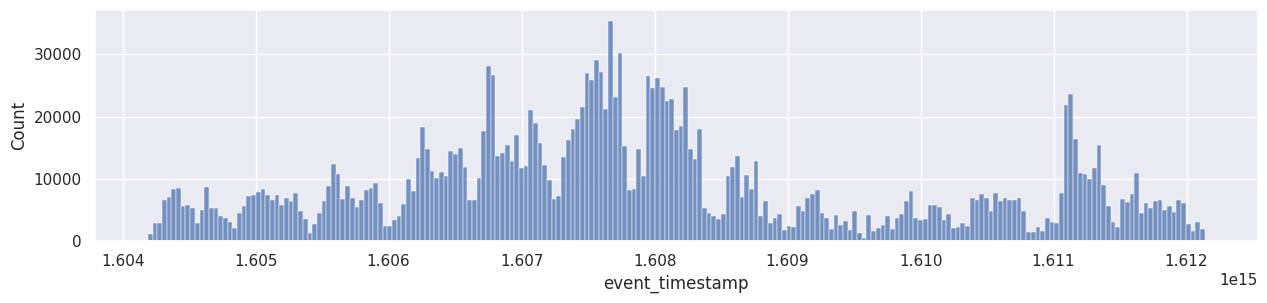

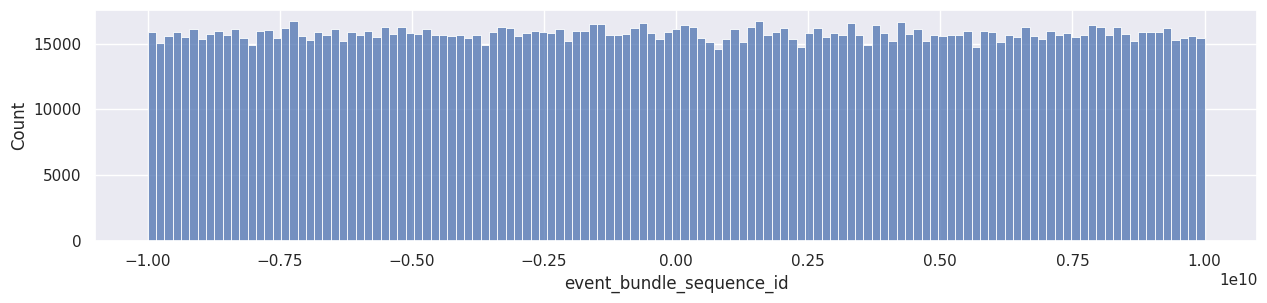

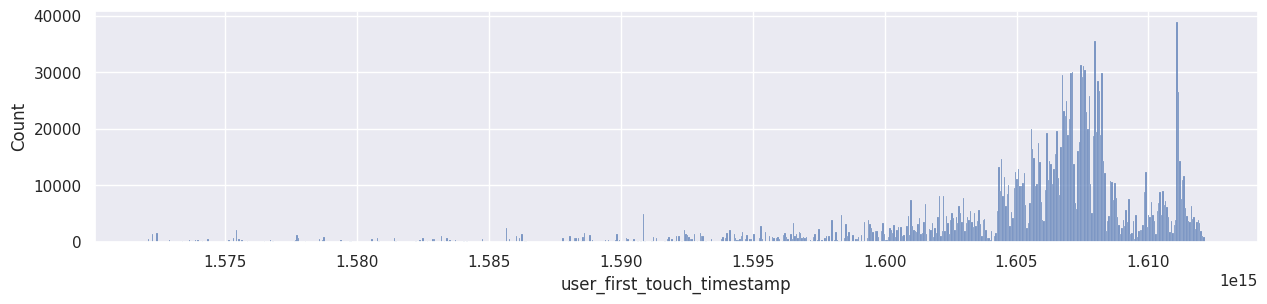

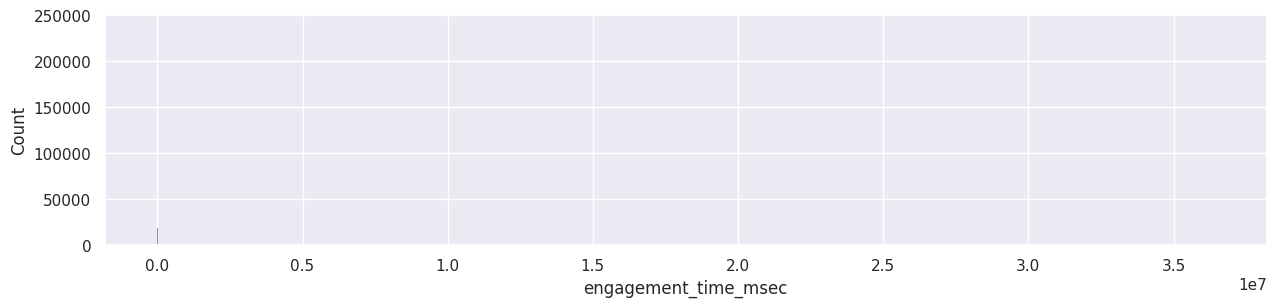

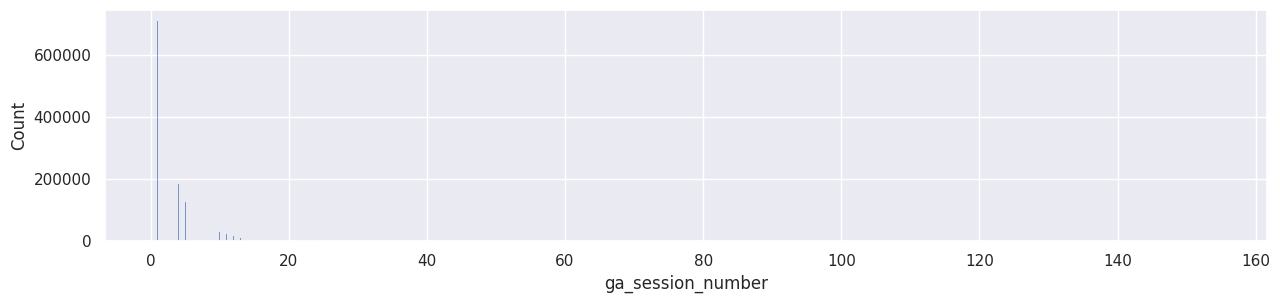

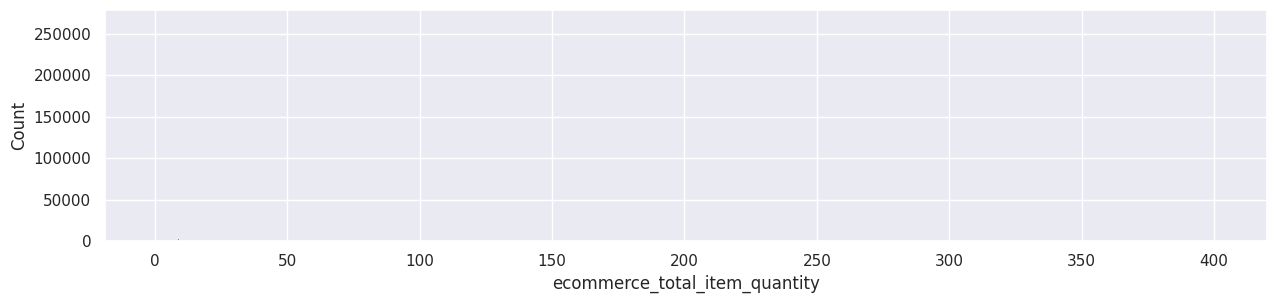

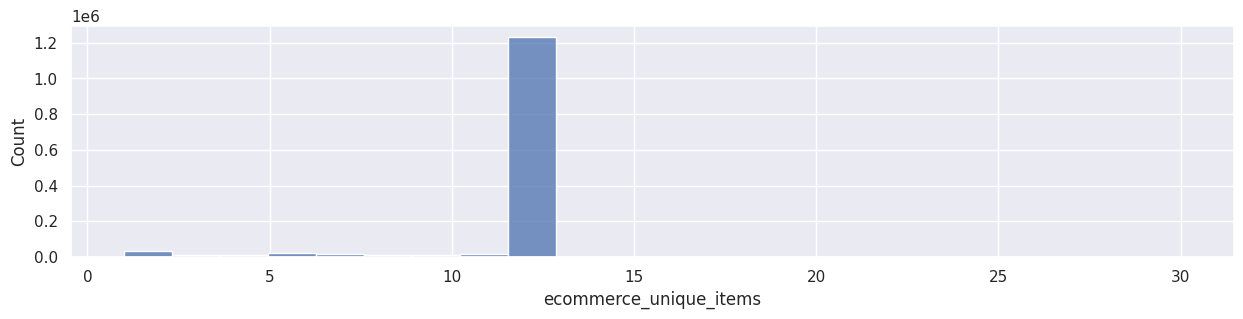

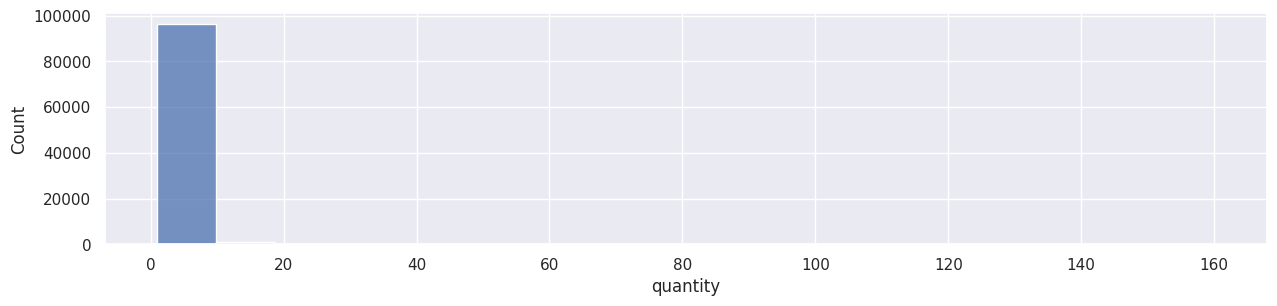

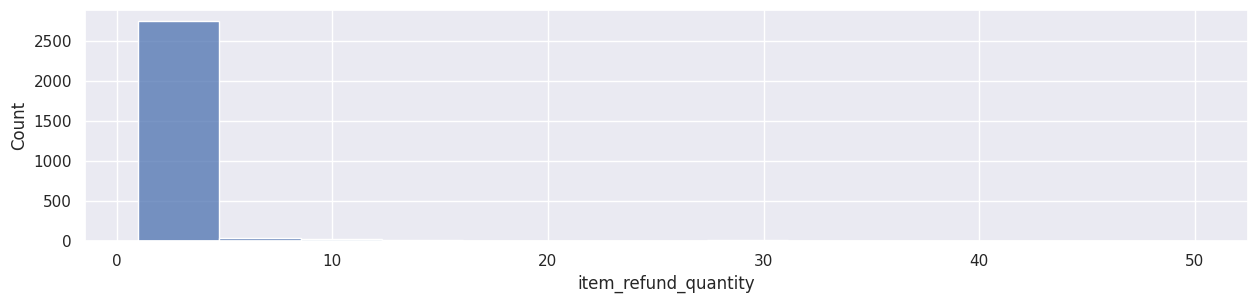

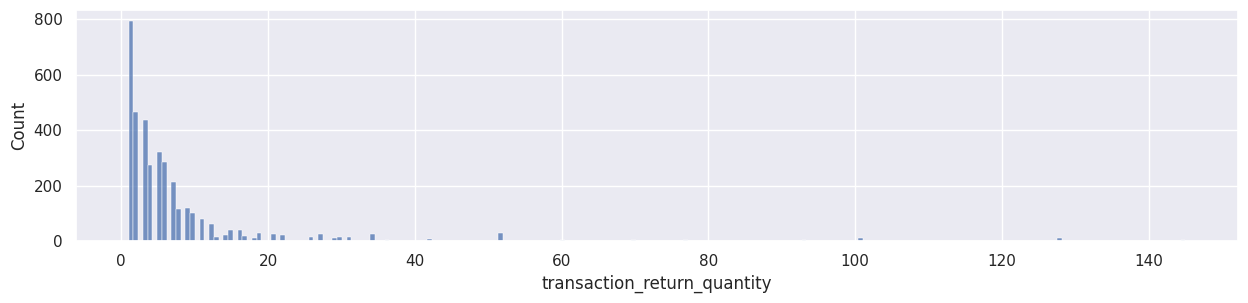

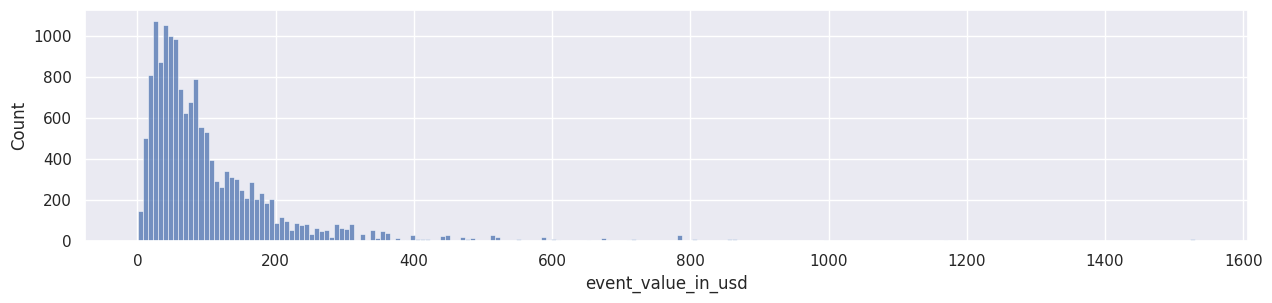

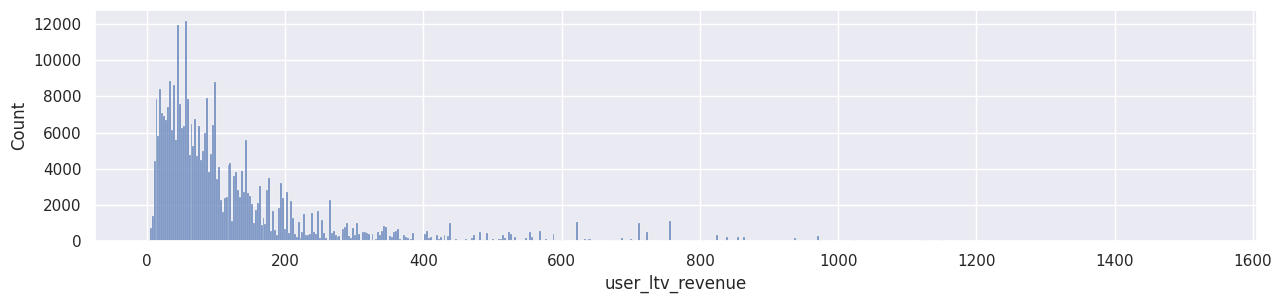

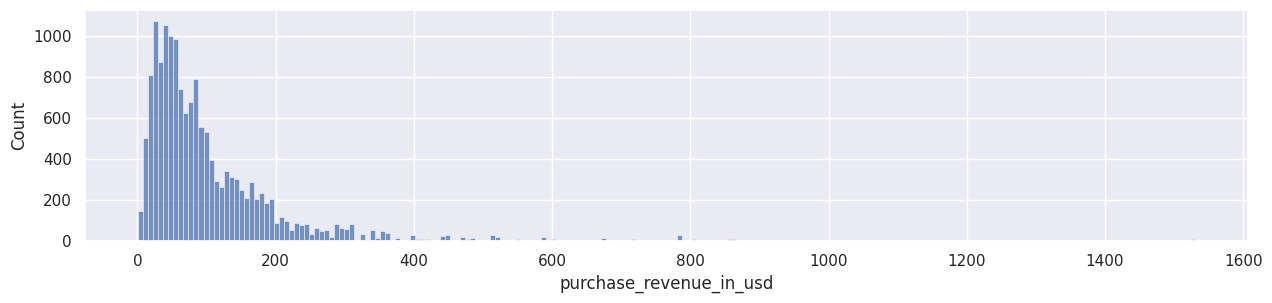

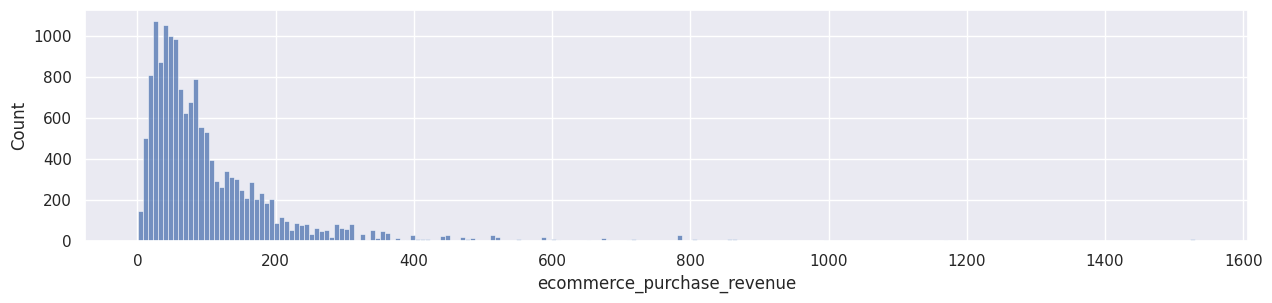

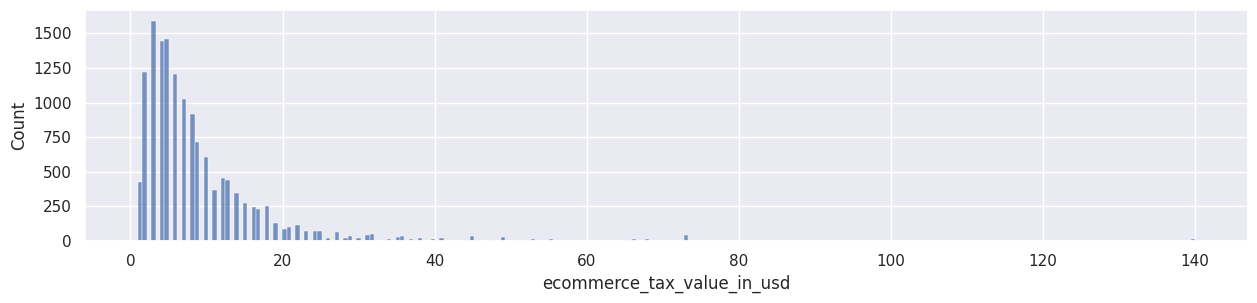

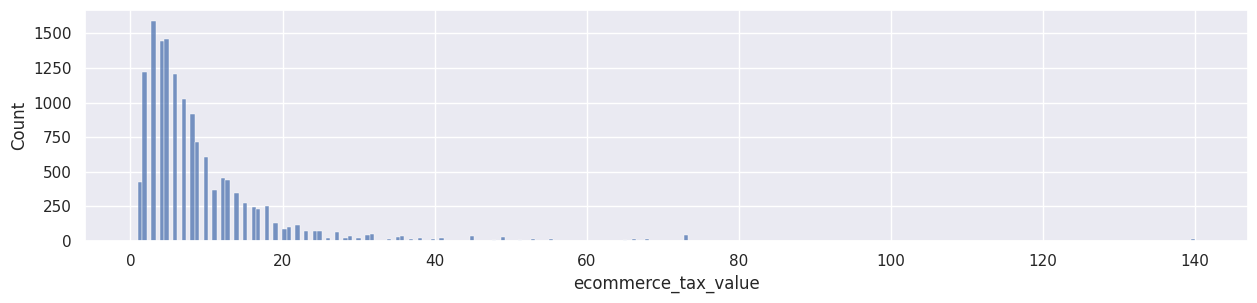

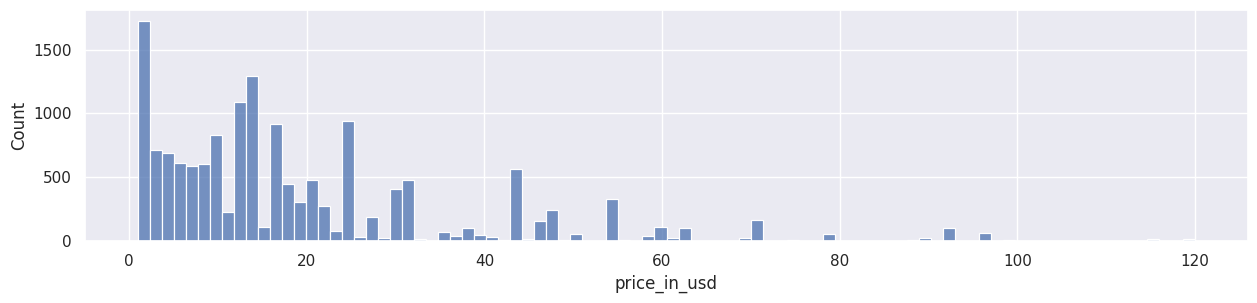

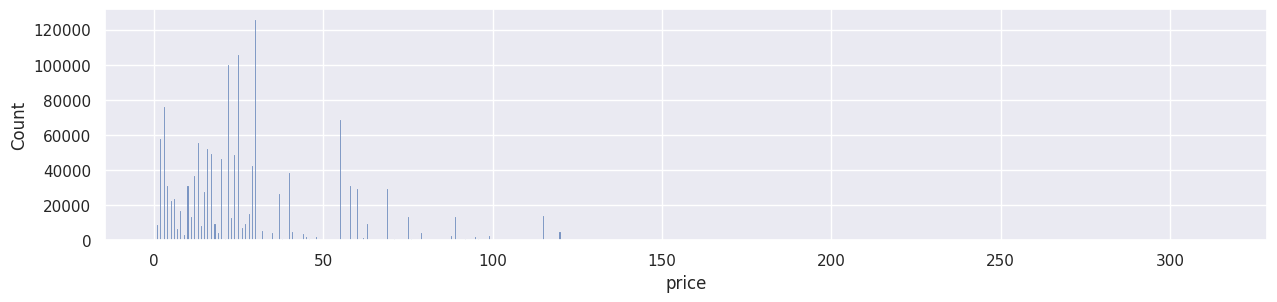

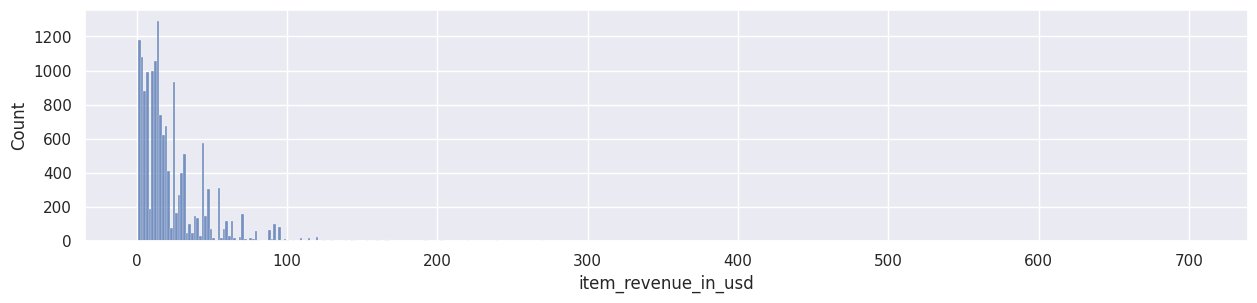

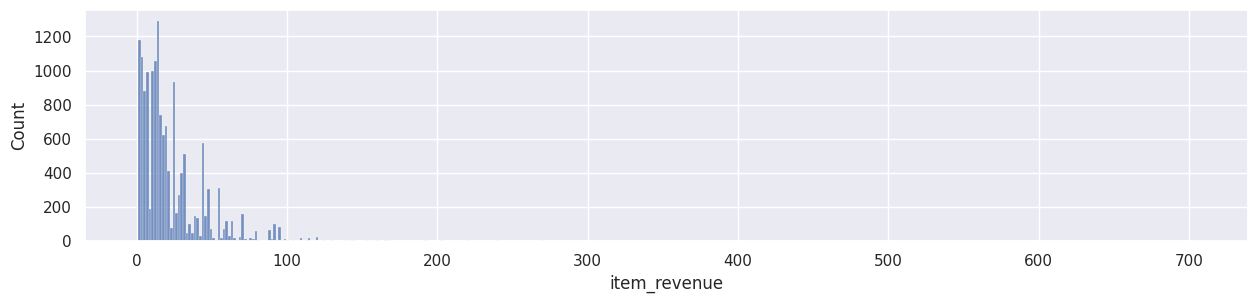

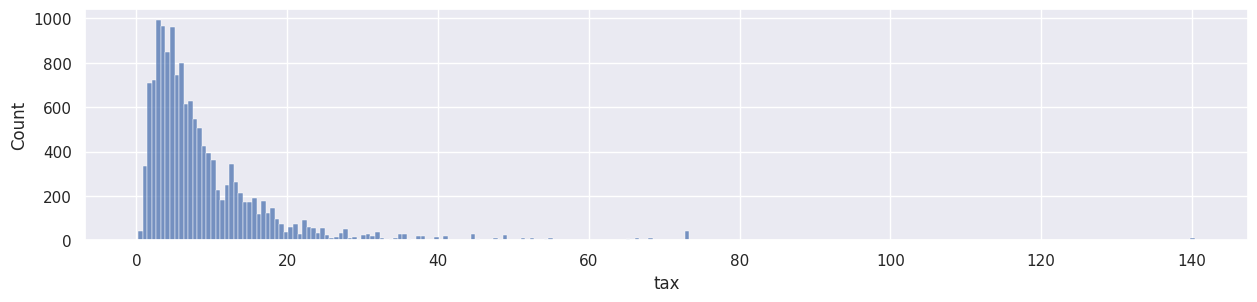

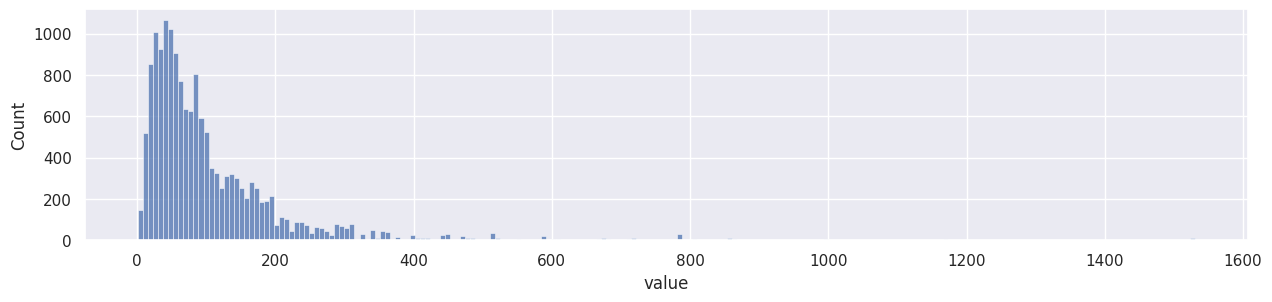

In [ ]:
# plot distributions of numeric features
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.histplot(data = df_pivot[df_pivot[col] != 0],x = col)
    plt.show();

### Numeric feature summary
*Feature descriptions are taken from the GA4 BigQuery Export schema reference page: https://support.google.com/analytics/answer/7029846?hl=en*
* `event_timestamp`:
    - The time (in microseconds, UTC) when the event was logged on the client.
        - This feature is overly specific, `event_date` should suffice as the timestamp feature.
        - **Drop this column.**
* `event_bundle_sequence_id`:
    - The sequential ID of the bundle in which these events were uploaded.
        - This is an ID column with a uniform distribution, it is not likely to be predictive of a return.
        - **Drop this column.**
* `user_first_touch_timestamp`:
    - The time (in microseconds) at which the user first opened the app or visited the site.
        - This feature can likely be inferred from event_timestamp and includes missing values where event_timestamp does not.
        - **Drop this column.**
* `engagement_time_msec`:
    - Total time of the session spent engaged expressed in milliseconds.
        - This feature could be useful in predicting returns.
        - We'll find the total engagment time for each user.
* `ga_session_number`:
    - The session number for this user. If this is the first session, then this is set to 1.
        - This feature could be useful in predicting returns.
        - We'll find the maximum session number for each user.
* `ecommerce_total_item_quantity`:
    - Total number of items in this event, which is the sum of items.quantity.
        - This event is important for product or purchase related data, which could be useful in predicting returns.
        - We'll find the total item quantity for each user.
* `ecommerce_unique_items`:
    - The number of unique items in this event, based on item_id, item_name, and item_brand.
        - This event is important for product or purchase related data, which could be useful in predicting returns.
        - We'll find the total unique quantity for each user.
* `items.quantity`:
    - The quantity of the item. Quantity set to 1 if not specified.
        - This event is important for product or purchase related data, which could be useful in predicting returns.
        - We may find later that aggregating this value is equal to one of our other values. At that point, we may drop this feature.
* `item_refund_quantity`:
    - The refund quantity of the item.
        - This event is important for product or purchase related data and is our target.
        - We will be aggregating this to the transaction level, and calculating a dollar amount based on the item price.
* `transaction_return_quantity`:
    - Total number of refunded items in this event.
        - This event is important for product or purchase related data and is our target.
        - We will calculating a dollar amount based on the item price.
* `event_value_in_usd`:
    - The currency-converted value (in USD) of the event's "value" parameter.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.
* `user_ltv_revenue`:
    - The Lifetime Value (revenue) of the user. This field is not populated in intraday tables.
        - This feature could be useful in predicting returns.
        - We'll find the maximum LTV value for each user.
* `purchase_revenue_in_usd`:
    - Purchase revenue of this event, represented in USD with standard unit. Populated for purchase event only.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.
* `ecommerce_purchase_revenue`:
    - Purchase revenue of this event, represented in local currency with standard unit. Populated for purchase event only.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.     
* `ecommerce_tax_value_in_usd`:
    - The tax value in this event, represented in USD with standard unit.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.
* `ecommerce_tax_value`:
    - The tax value in this event, represented in local currency with standard unit.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.
* `price_in_usd`:
    - The price of the item, in USD with standard unit.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.     
* `price`:
    - The price of the item in local currency.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.
* `item_revenue_in_usd`:
    - The revenue of this item, calculated as price_in_usd * quantity. It is populated for purchase events only, in USD with standard unit.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.     
* `item_revenue`:
    - The revenue of this item, calculated as price * quantity. It is populated for purchase events only, in local currency with standard unit.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.
* `tax`:
    - Total transaction tax, expressed as the value passed to Analytics.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.     
* `value`:
    - Total transaction revenue, expressed as the value passed to Analytics.
        - This event is important for product or purchase related data.
        - We'll aggregate this to the user level.

In [ ]:
drop_num_cols = ['event_timestamp', 'event_bundle_sequence_id', 'user_first_touch_timestamp']

Based on the summary statistics below, we may be able to eliminate some redundant numeric features.

In [ ]:
df_pivot[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
key,,,,,,,,
event_timestamp,2002010.000,1607916021936942.500,1942829552350.362,1604189395117321.000,1606664582713791.000,1607661601505751.000,1608896920106355.000,1612136276965135.000
event_bundle_sequence_id,2002010.000,-5321516.545,5766875937.905,-9999995056.000,-5001175605.250,-23289079.000,4981322458.000,9999982755.000
user_first_touch_timestamp,2002010.000,1569745784989028.250,237610371415998.188,0.000,1604548224574065.000,1606855343315178.000,1608108912192442.000,1612132601258613.000
engagement_time_msec,2002010.000,10536.342,42128.630,0.000,271.000,4365.000,11406.000,36399379.000
ga_session_number,2002010.000,3.625,4.303,1.000,1.000,2.000,5.000,154.000
ecommerce_total_item_quantity,2002010.000,0.490,3.013,0.000,0.000,0.000,0.000,400.000
ecommerce_unique_items,2002010.000,7.808,5.598,0.000,0.000,12.000,12.000,30.000
quantity,2002010.000,0.071,0.671,0.000,0.000,0.000,0.000,160.000
item_refund_quantity,2002010.000,0.002,0.116,0.000,0.000,0.000,0.000,50.000


`purchase_revenue_in_usd`, `ecommerce_purchase_revenue`,`event_value_in_usd`, and `value` all seem to contain the same information.

In [ ]:
print(sum(df_pivot['purchase_revenue_in_usd'] != df_pivot['ecommerce_purchase_revenue']))
print(sum(df_pivot['ecommerce_purchase_revenue'] != df_pivot['event_value_in_usd']))
print(sum(df_pivot['event_value_in_usd'] != df_pivot['value']))
print(sum(df_pivot['purchase_revenue_in_usd'] != df_pivot['value']))
print(sum(df_pivot['purchase_revenue_in_usd'] != df_pivot['event_value_in_usd']))
print(sum(df_pivot['ecommerce_purchase_revenue'] != df_pivot['value']))

0
0
11961
11961
0
11961


In [ ]:
df_pivot[df_pivot['purchase_revenue_in_usd'] != df_pivot['value']][['purchase_revenue_in_usd', 'value']]

key,purchase_revenue_in_usd,value
741,87.000,87.300
742,87.000,87.300
743,87.000,87.300
744,87.000,87.300
1156,46.000,46.240
...,...,...
1994970,28.000,27.750
1994971,28.000,27.750
1996658,28.000,28.320
1996659,28.000,28.320


There are some instances in which `value` is not equal to `purchase_revenue_in_usd`, however, they are usually only only a few cents different. I am choosing to retain `purchase_revenue_in_usd`.

In [ ]:
drop_num_cols += ['ecommerce_purchase_revenue', 'event_value_in_usd', 'value']

`ecommerce_tax_value_in_usd`, `ecommerce_tax_value`, and `tax` all seem to contain the same information.

In [ ]:
print(sum(df_pivot['ecommerce_tax_value_in_usd'] != df_pivot['ecommerce_tax_value']))
print(sum(df_pivot['ecommerce_tax_value'] != df_pivot['tax']))
print(sum(df_pivot['ecommerce_tax_value_in_usd'] != df_pivot['tax']))

0
14270
14270


In [ ]:
df_pivot[df_pivot['ecommerce_tax_value_in_usd'] != df_pivot['tax']][['ecommerce_tax_value_in_usd', 'tax']]

key,ecommerce_tax_value_in_usd,tax
177,2.000,2.140
178,2.000,2.140
430,7.000,6.960
431,7.000,6.960
622,3.000,2.840
...,...,...
1994971,3.000,2.950
1995292,1.000,1.250
1996658,2.000,1.770
1996659,2.000,1.770


There are some instances in which `tax` is not equal to `ecommerce_tax_value_in_usd`, however, they are usually only only a few cents different. I am choosing to retain `ecommerce_tax_value_in_usd`.

In [ ]:
drop_num_cols += ['ecommerce_tax_value', 'tax']

Since I'm interested in keeping all my monetary values in USD, I'll drop `price` and retain `price_in_usd`, along with retaining `item_revenue_in_usd` over `item_revenue`.

In [ ]:
drop_num_cols += ['price', 'item_revenue']

In [ ]:
df_pivot = df_pivot.drop(drop_num_cols, axis=1)

In [ ]:
df_pivot.select_dtypes(np.number)

key,price_in_usd,quantity,item_revenue_in_usd,user_ltv_revenue,ecommerce_total_item_quantity,purchase_revenue_in_usd,ecommerce_tax_value_in_usd,ecommerce_unique_items,item_refund_quantity,transaction_return_quantity,engagement_time_msec,ga_session_number
0,0.000,0,0.000,0.000,0,0.000,0.000,0,0,0,0,1
1,0.000,0,0.000,0.000,0,0.000,0.000,0,0,0,0,1
2,0.000,0,0.000,0.000,0,0.000,0.000,0,0,0,0,1
3,0.000,0,0.000,0.000,0,0.000,0.000,0,0,0,8919,1
4,0.000,0,0.000,0.000,0,0.000,0.000,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2002005,0.000,0,0.000,0.000,0,0.000,0.000,0,0,0,0,3
2002006,0.000,0,0.000,0.000,0,0.000,0.000,0,0,0,22760,3
2002007,0.000,0,0.000,0.000,0,0.000,0.000,0,0,0,0,3
2002008,0.000,0,0.000,0.000,0,0.000,0.000,1,0,0,4,3


### Non-numeric features

In [ ]:
# inspecting non-numeric columns that are not records type; we'll handle records in the next notebook
non_num_cols = df_pivot.select_dtypes(exclude=np.number).columns

In [ ]:
# inspect the number of unique values in each non-numeric column
for col in non_num_cols:
    print(col)
    print(len(counts.get(col)))
    print("-" * 20)

event_date
92
--------------------
event_name
16
--------------------
user_pseudo_id
4419
--------------------
item_id
1377
--------------------
item_name
428
--------------------
item_brand
5
--------------------
item_variant
51
--------------------
item_category
68
--------------------
item_list_id
375
--------------------
item_list_index
36
--------------------
promotion_name
5
--------------------
device_category
3
--------------------
device_mobile_brand_name
8
--------------------
device_mobile_model_name
10
--------------------
device_operating_system
6
--------------------
device_operating_system_version
11
--------------------
device_language
9
--------------------
device_web_info_browser
6
--------------------
device_web_info_browser_version
10
--------------------
geo_continent
5
--------------------
geo_sub_continent
18
--------------------
geo_country
100
--------------------
geo_region
315
--------------------
geo_city
510
--------------------
traffic_source_medium
4
----

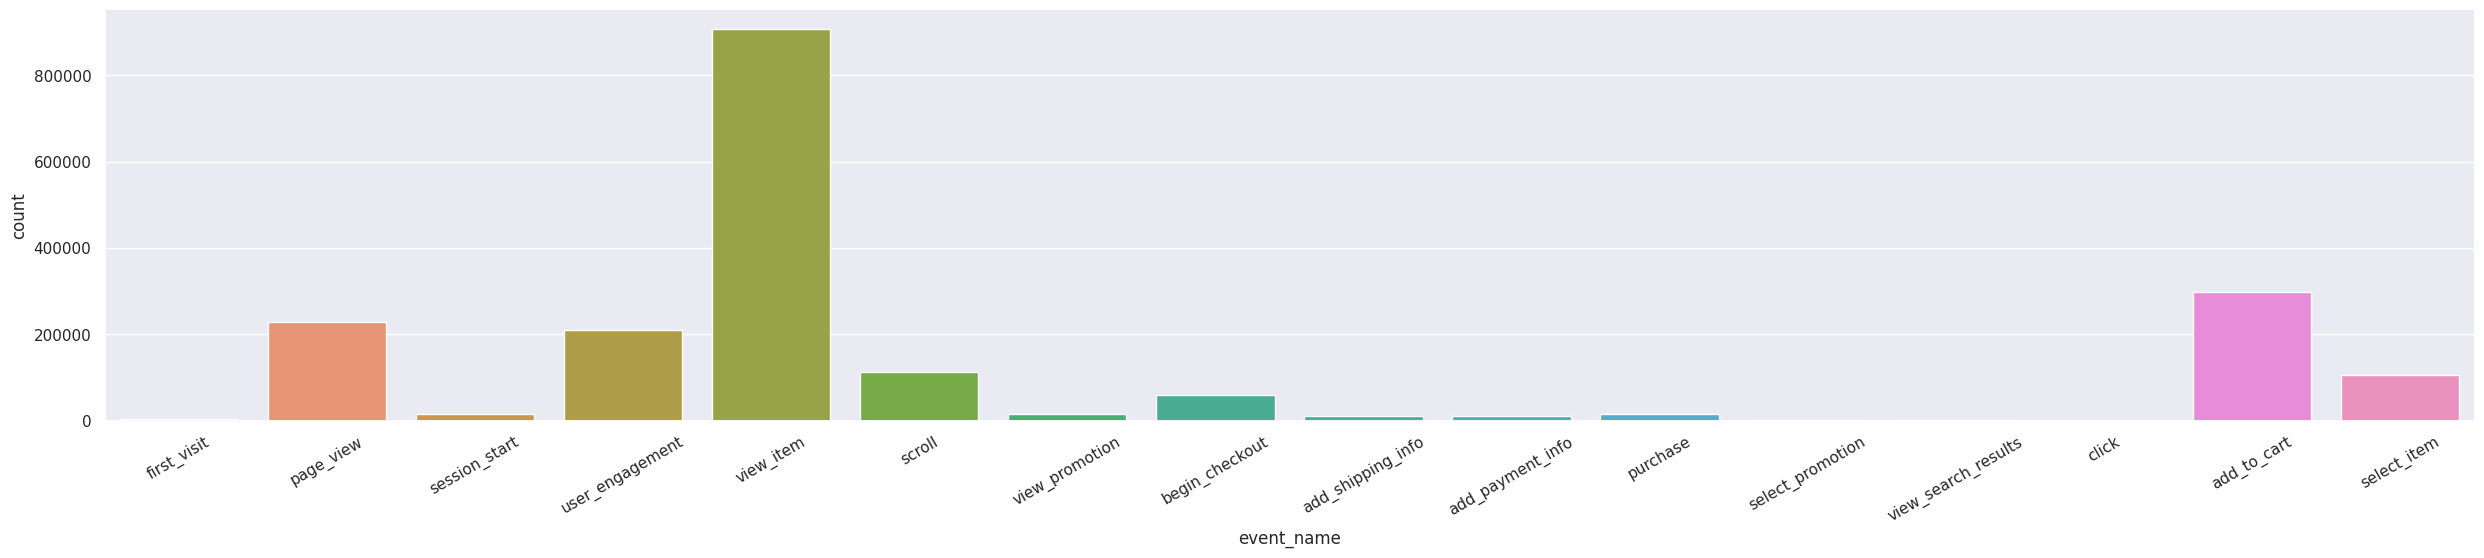

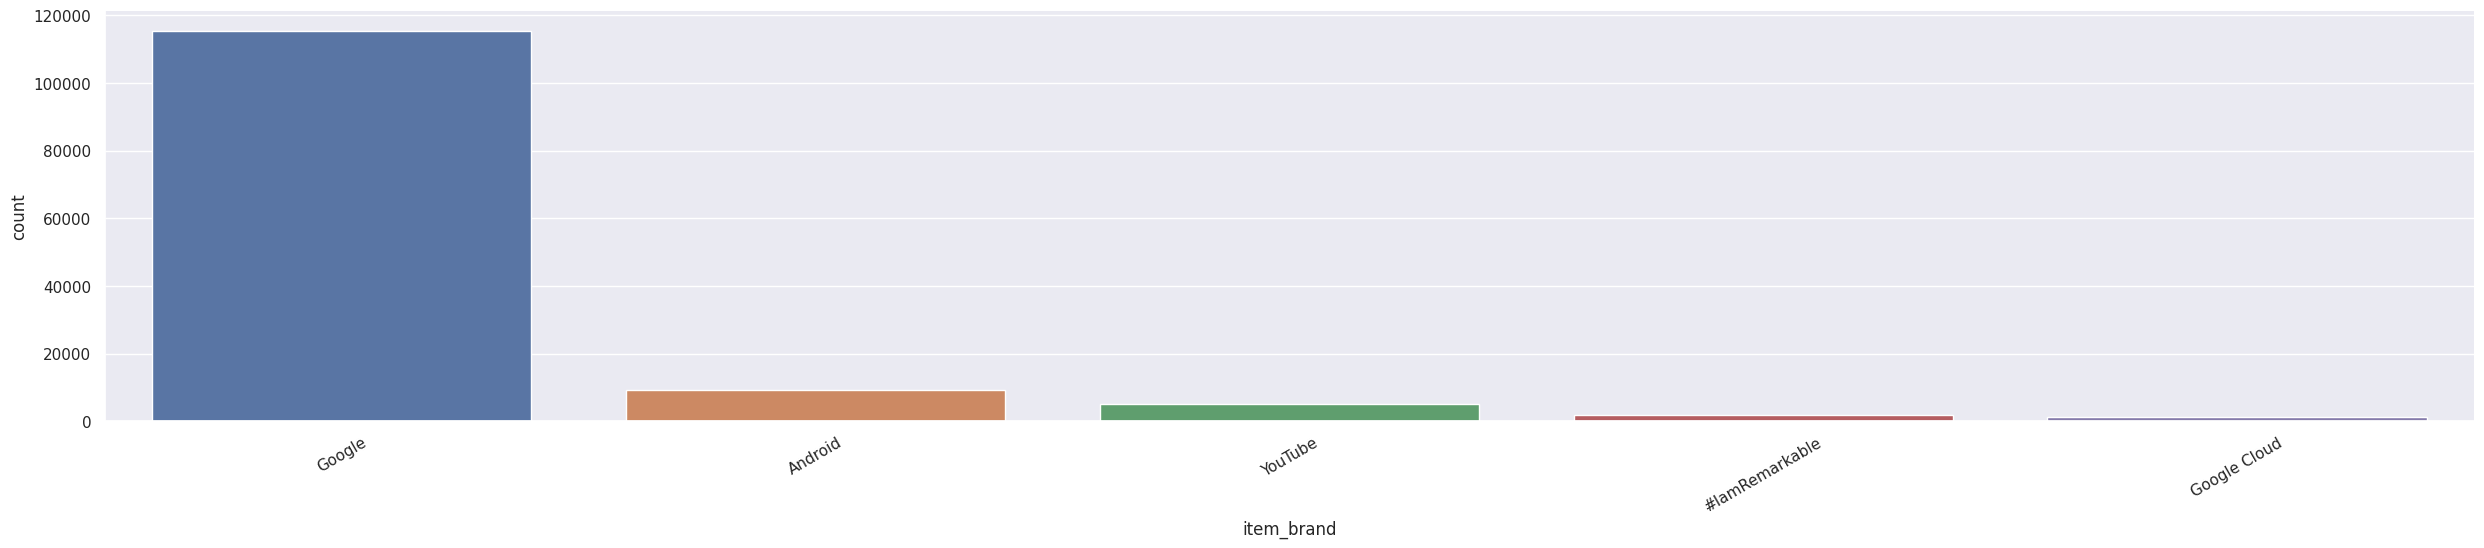

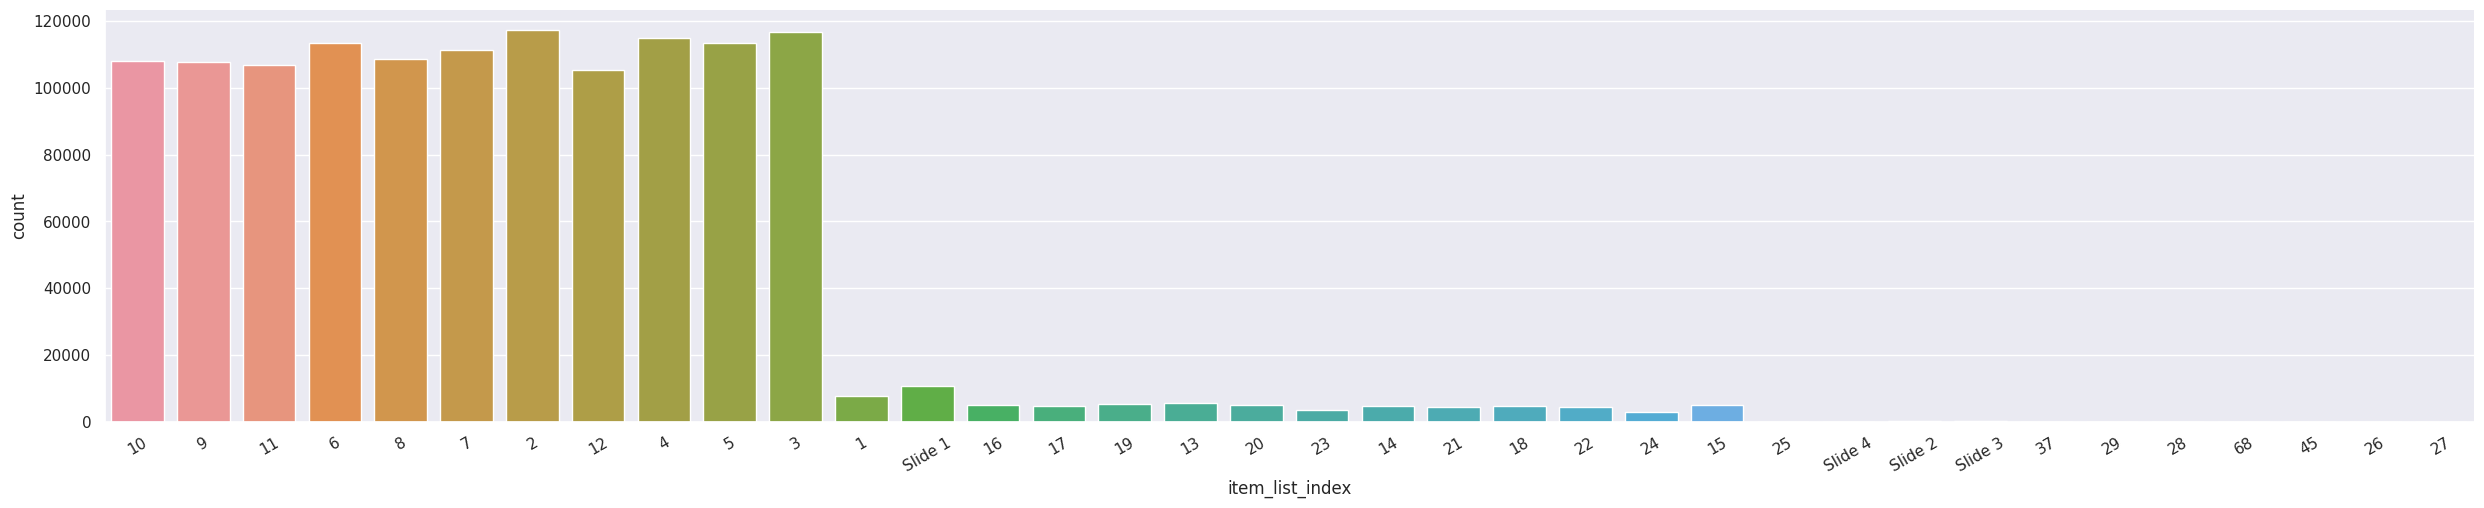

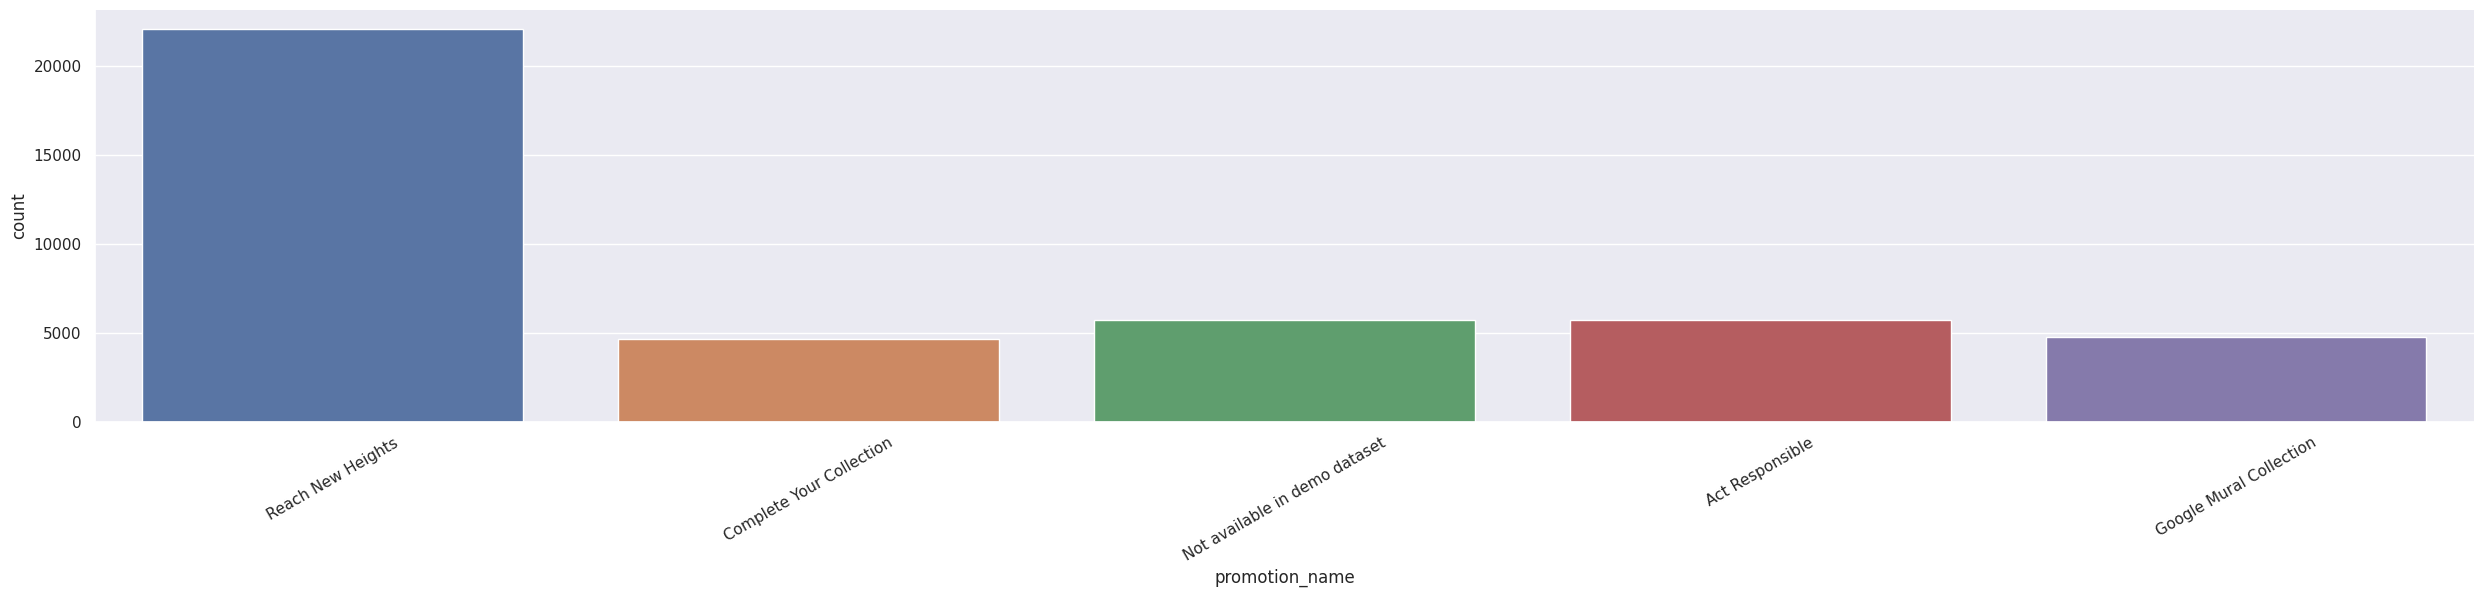

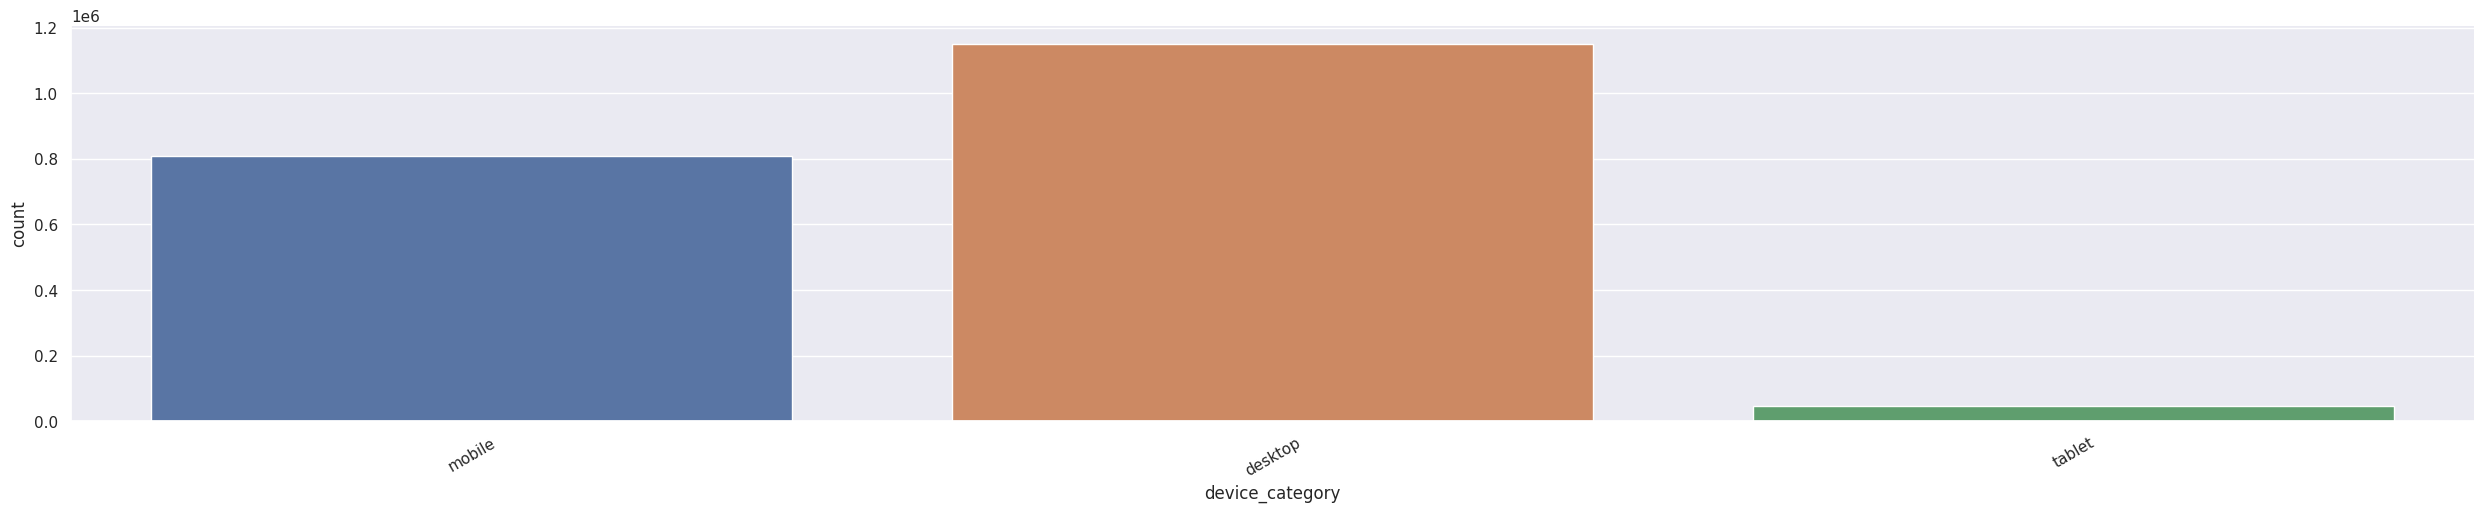

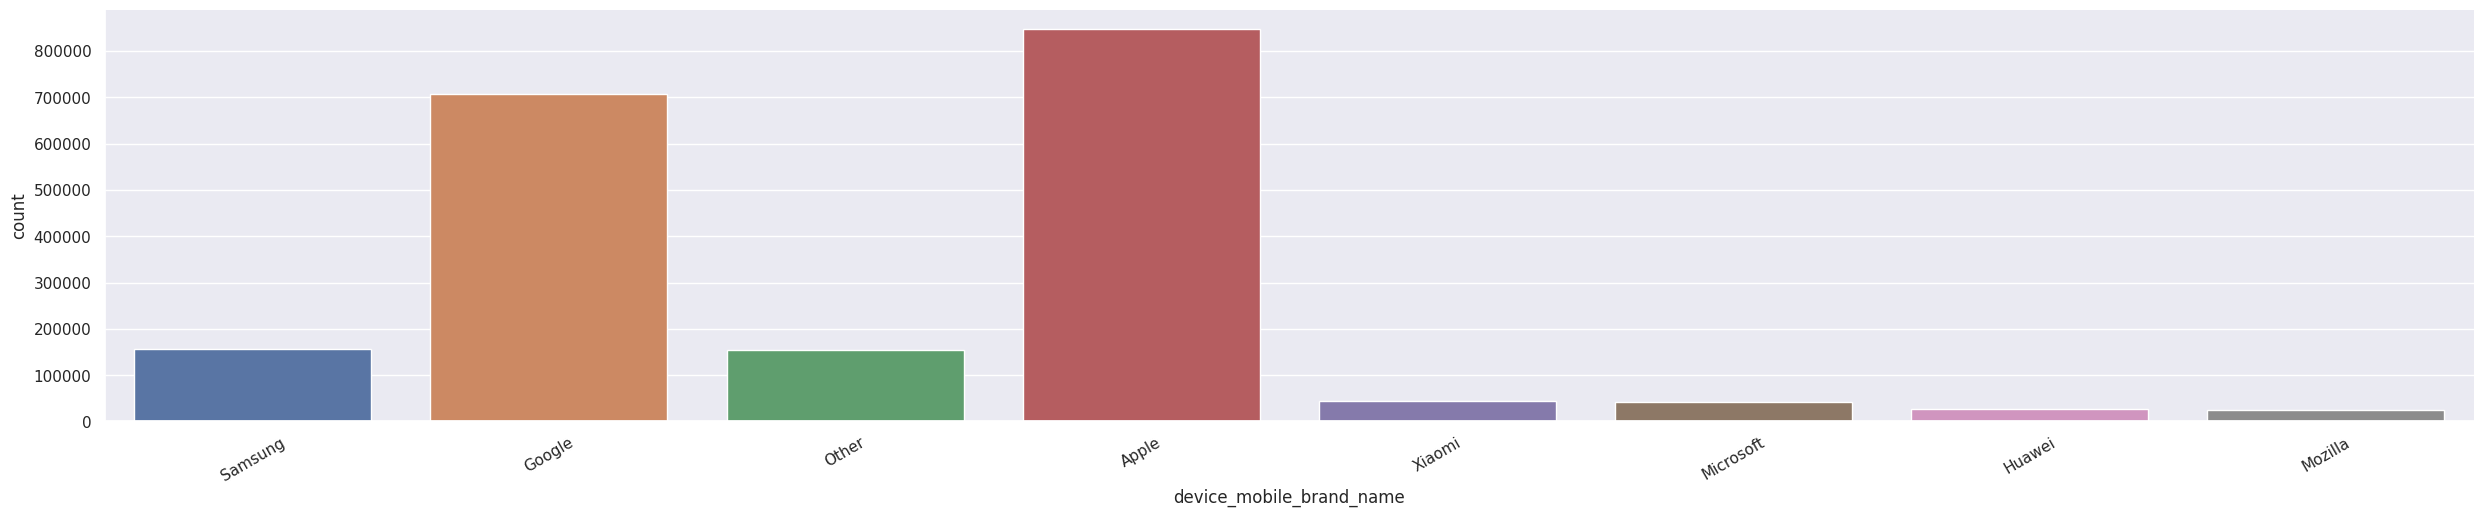

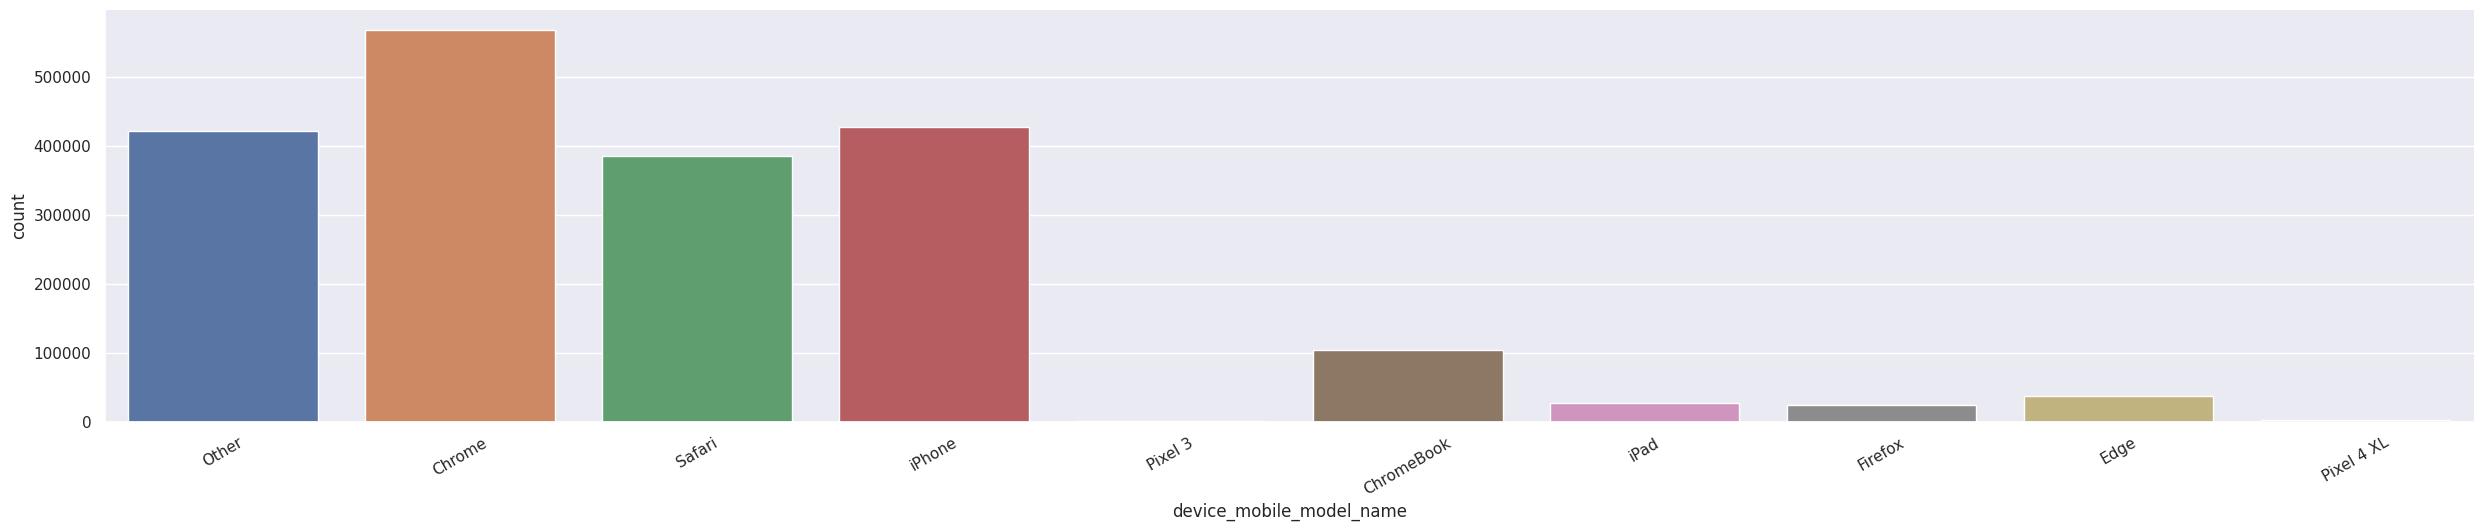

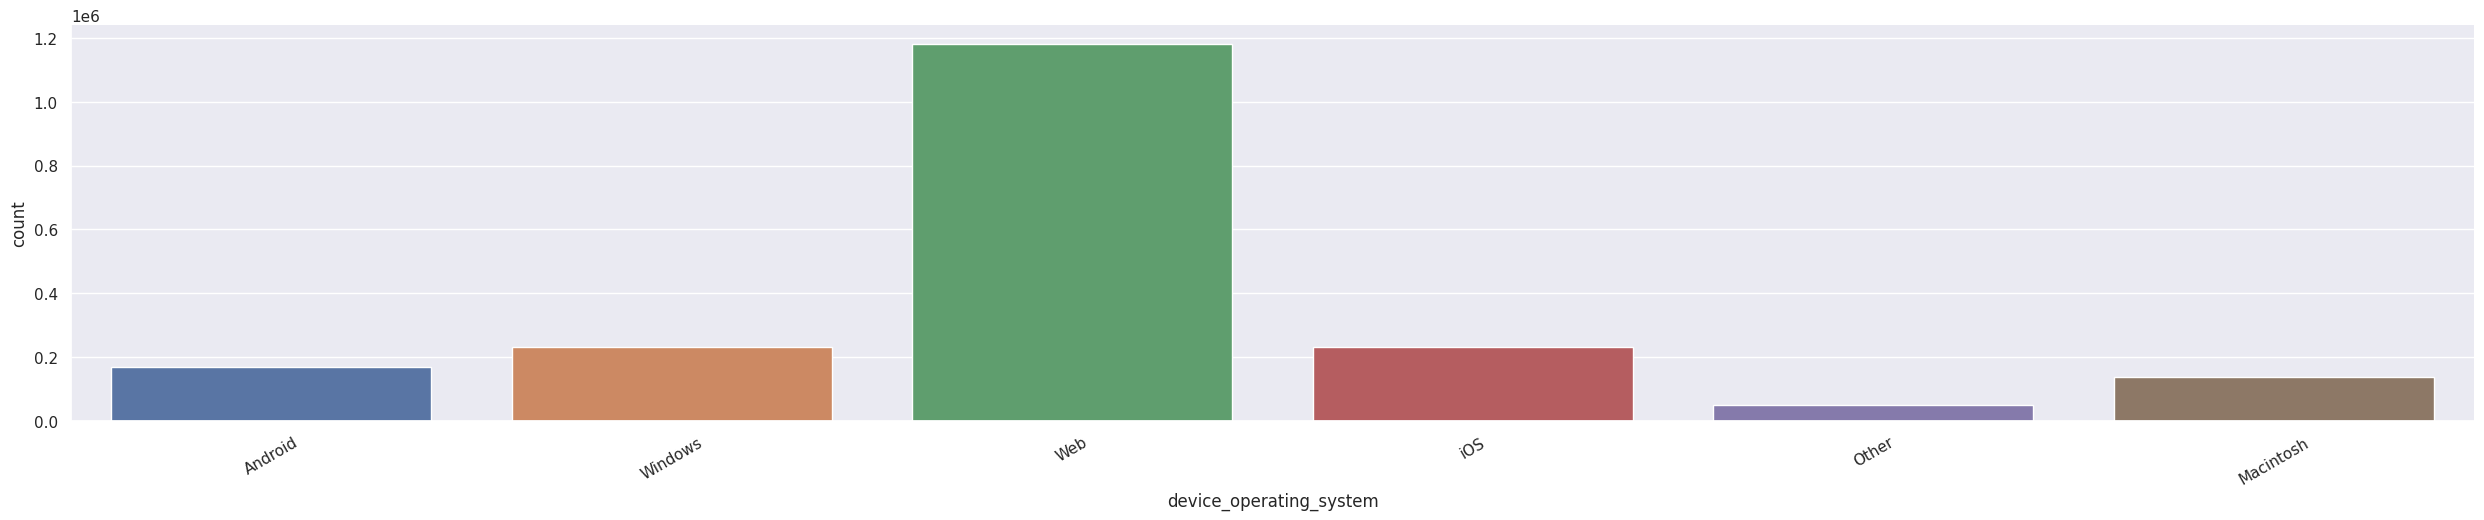

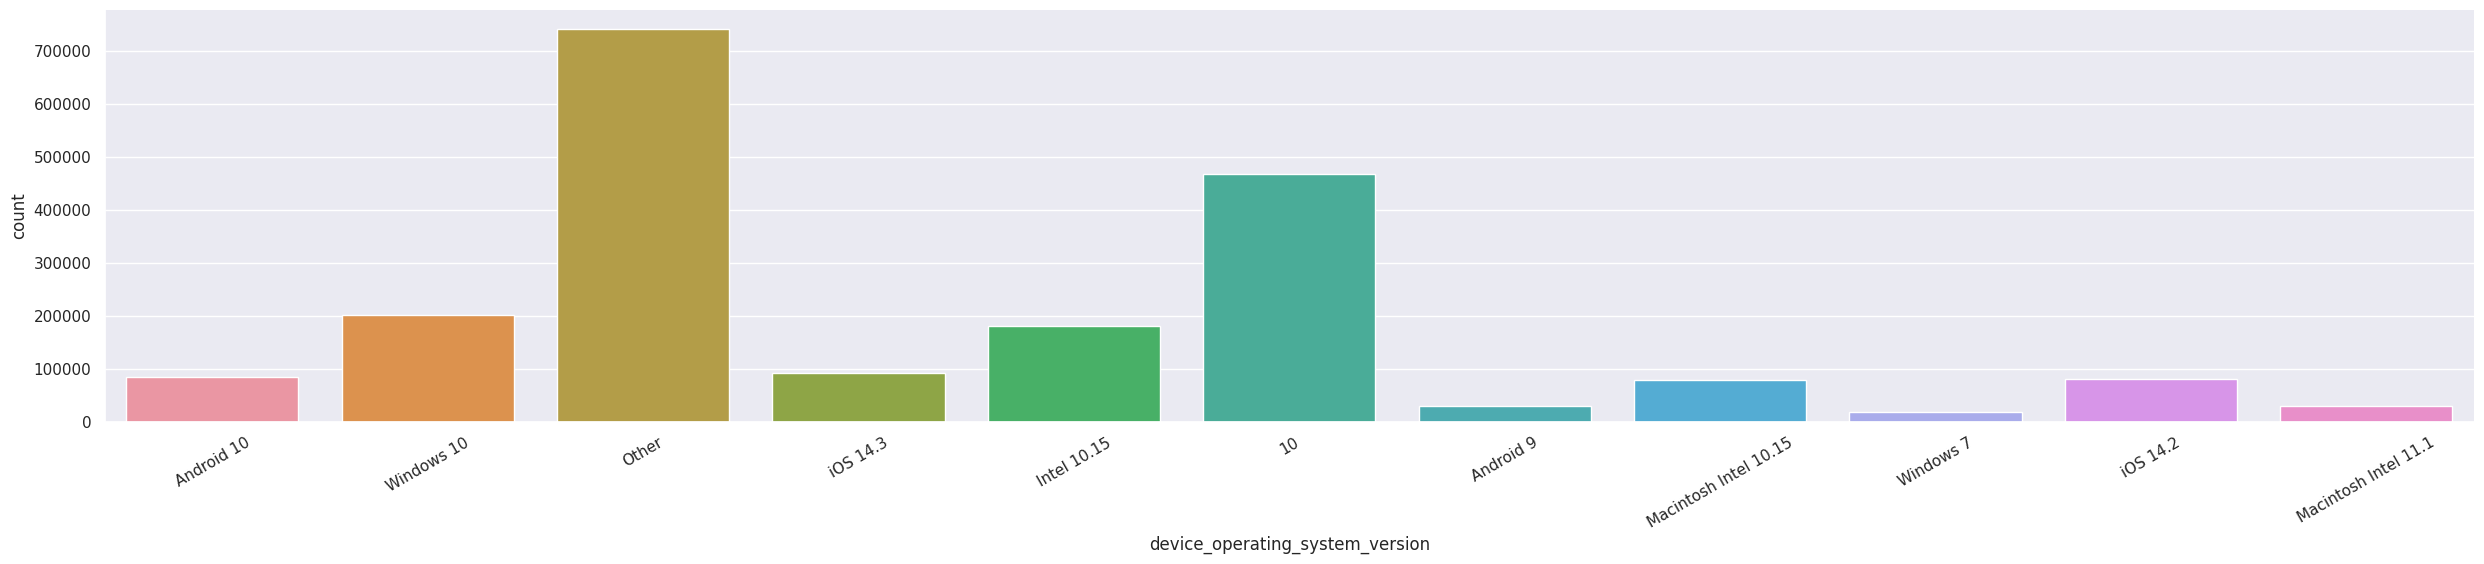

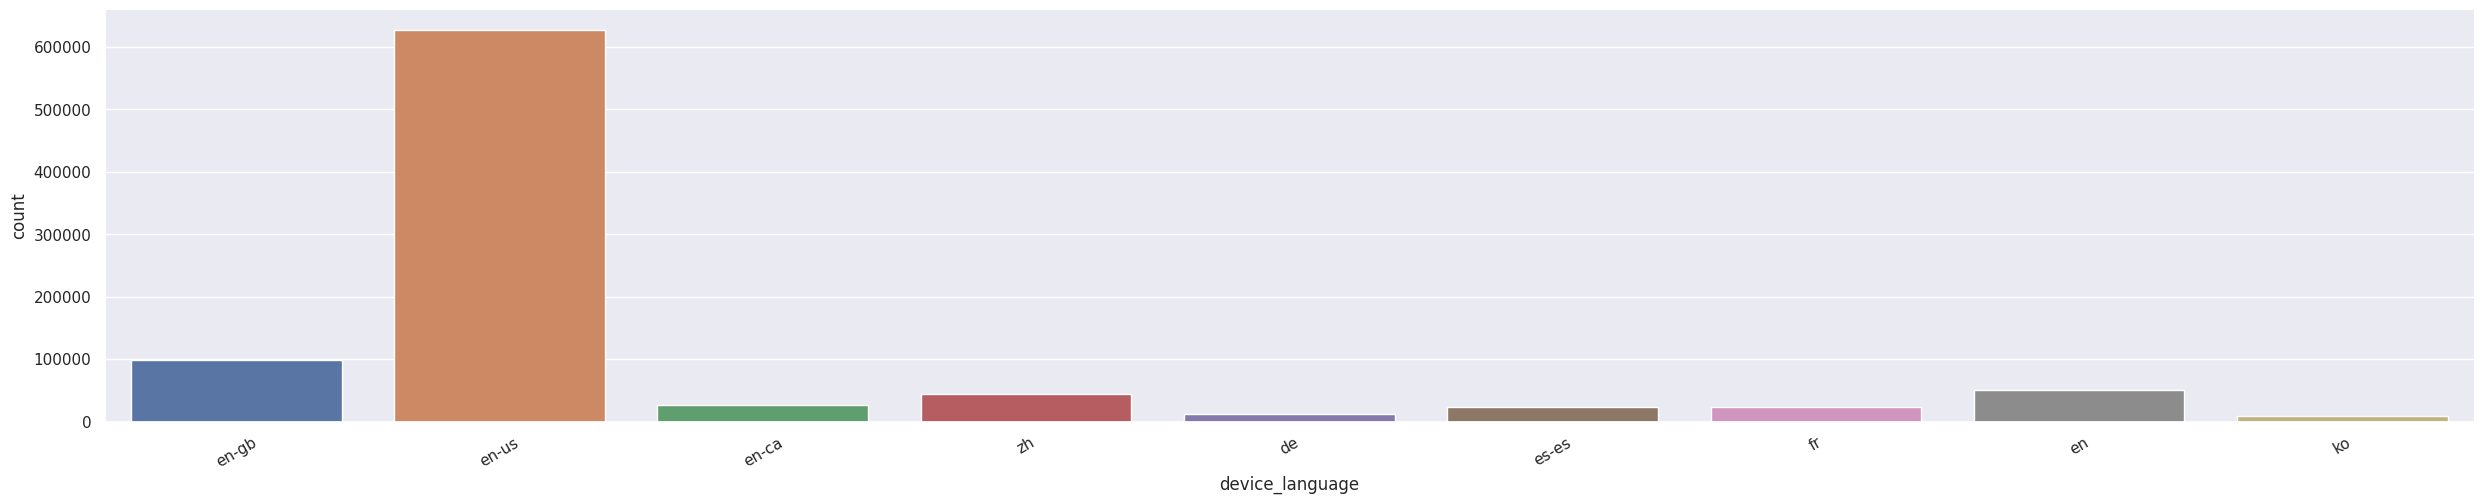

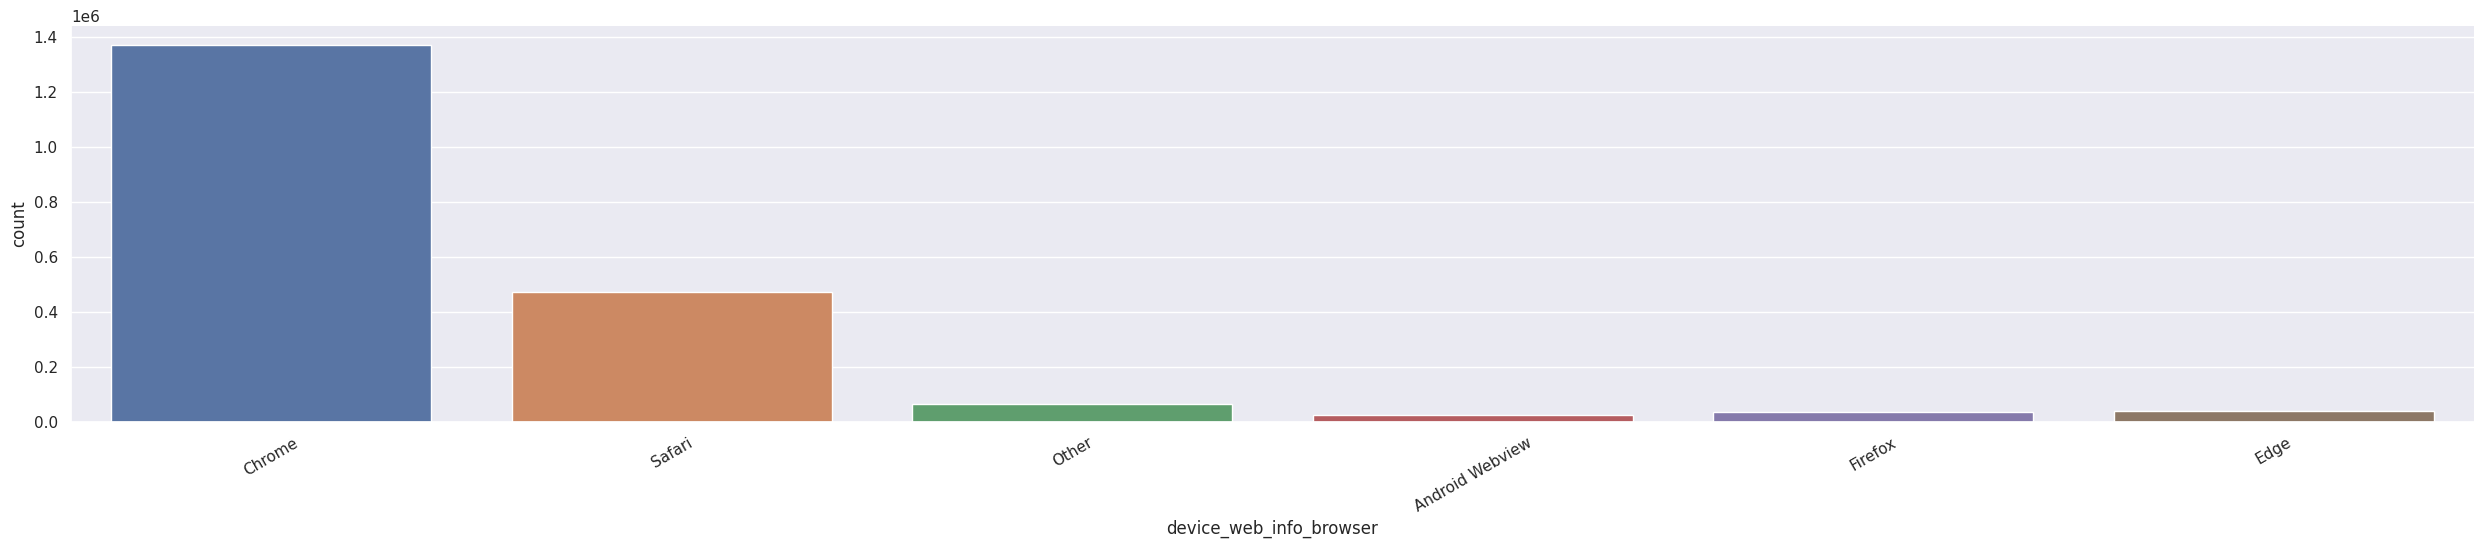

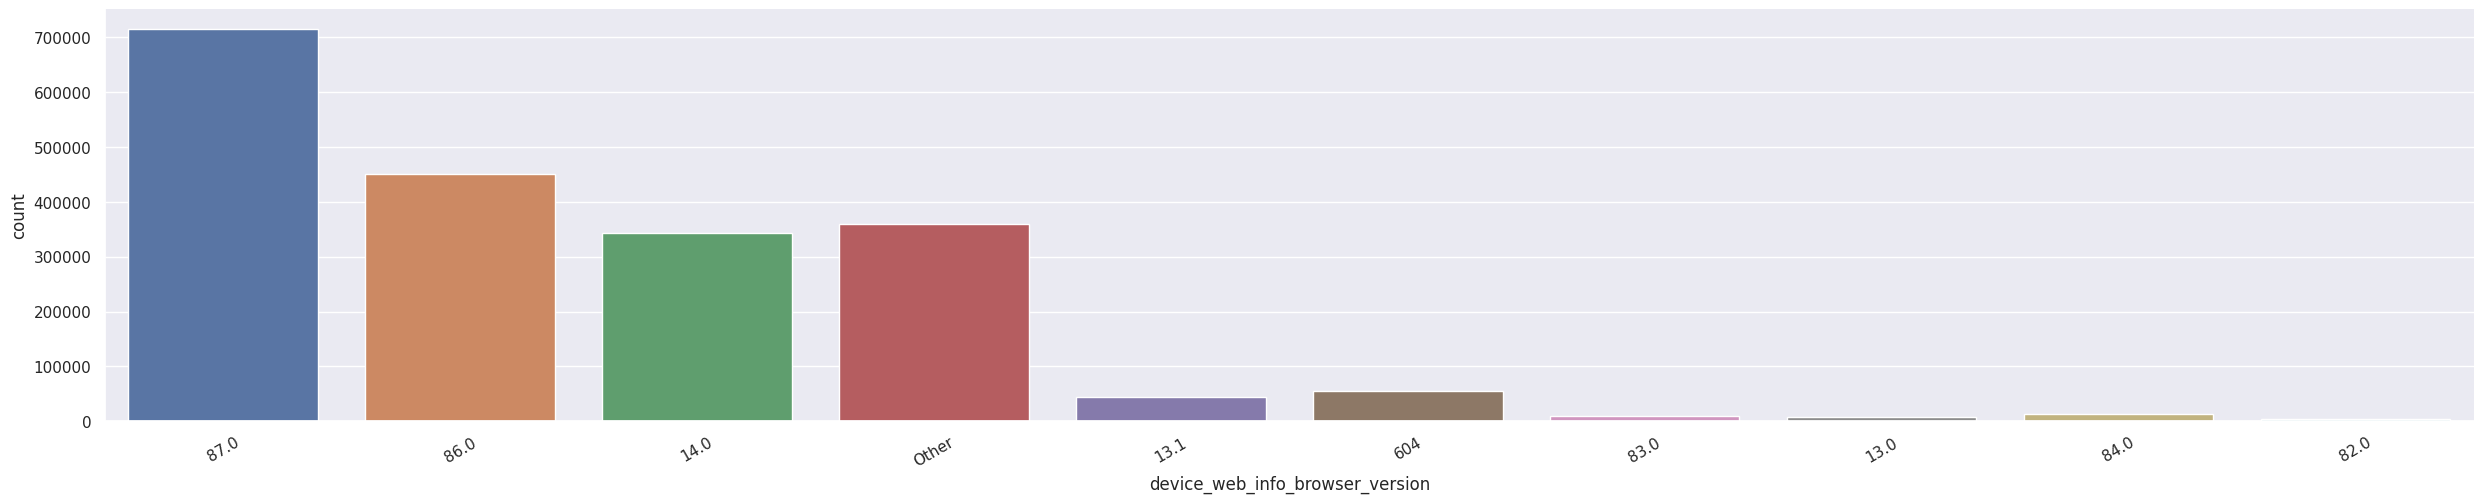

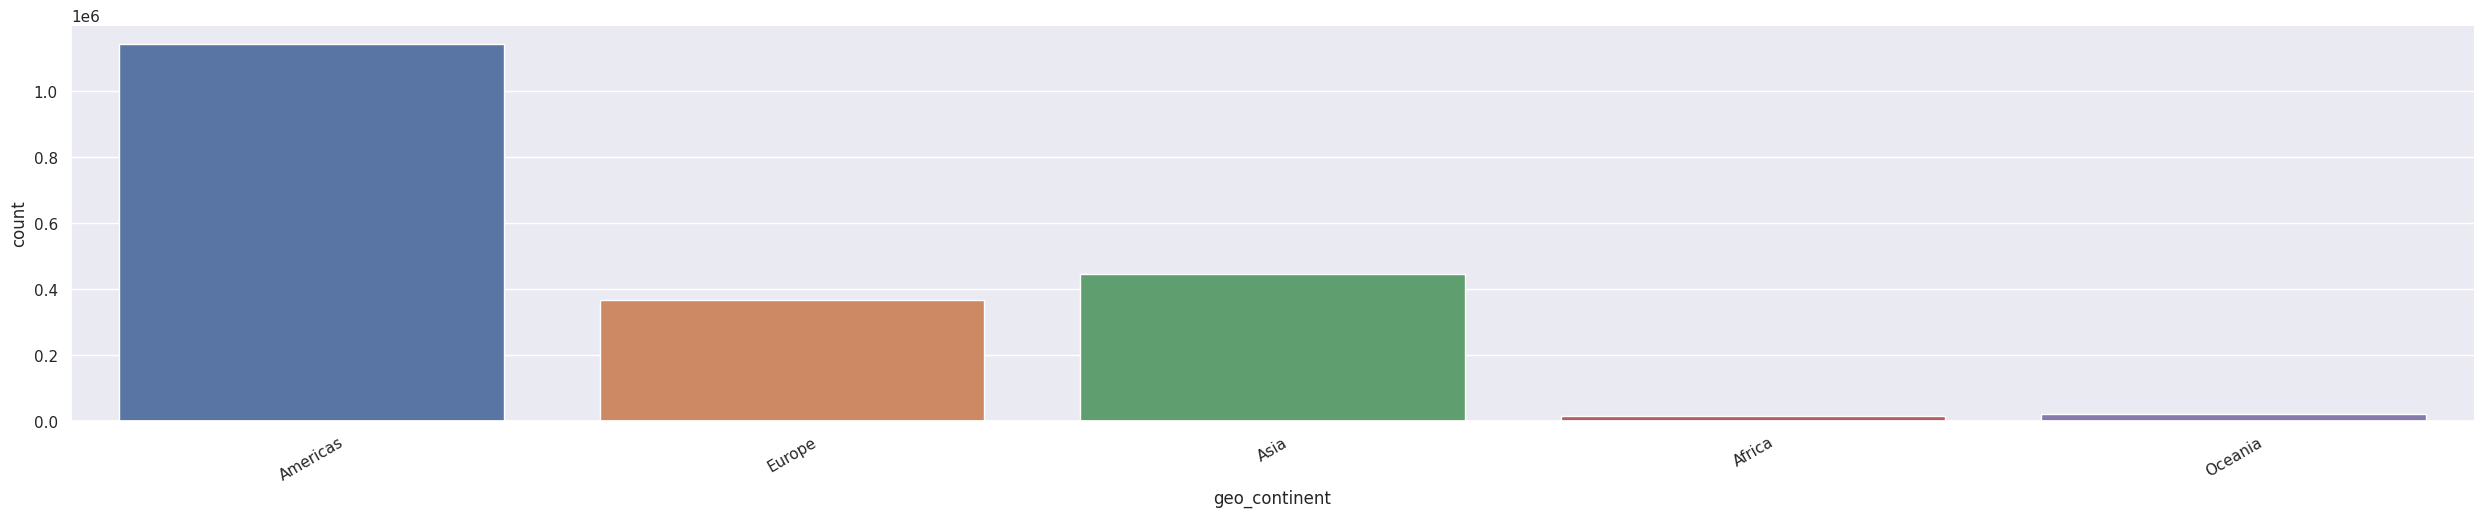

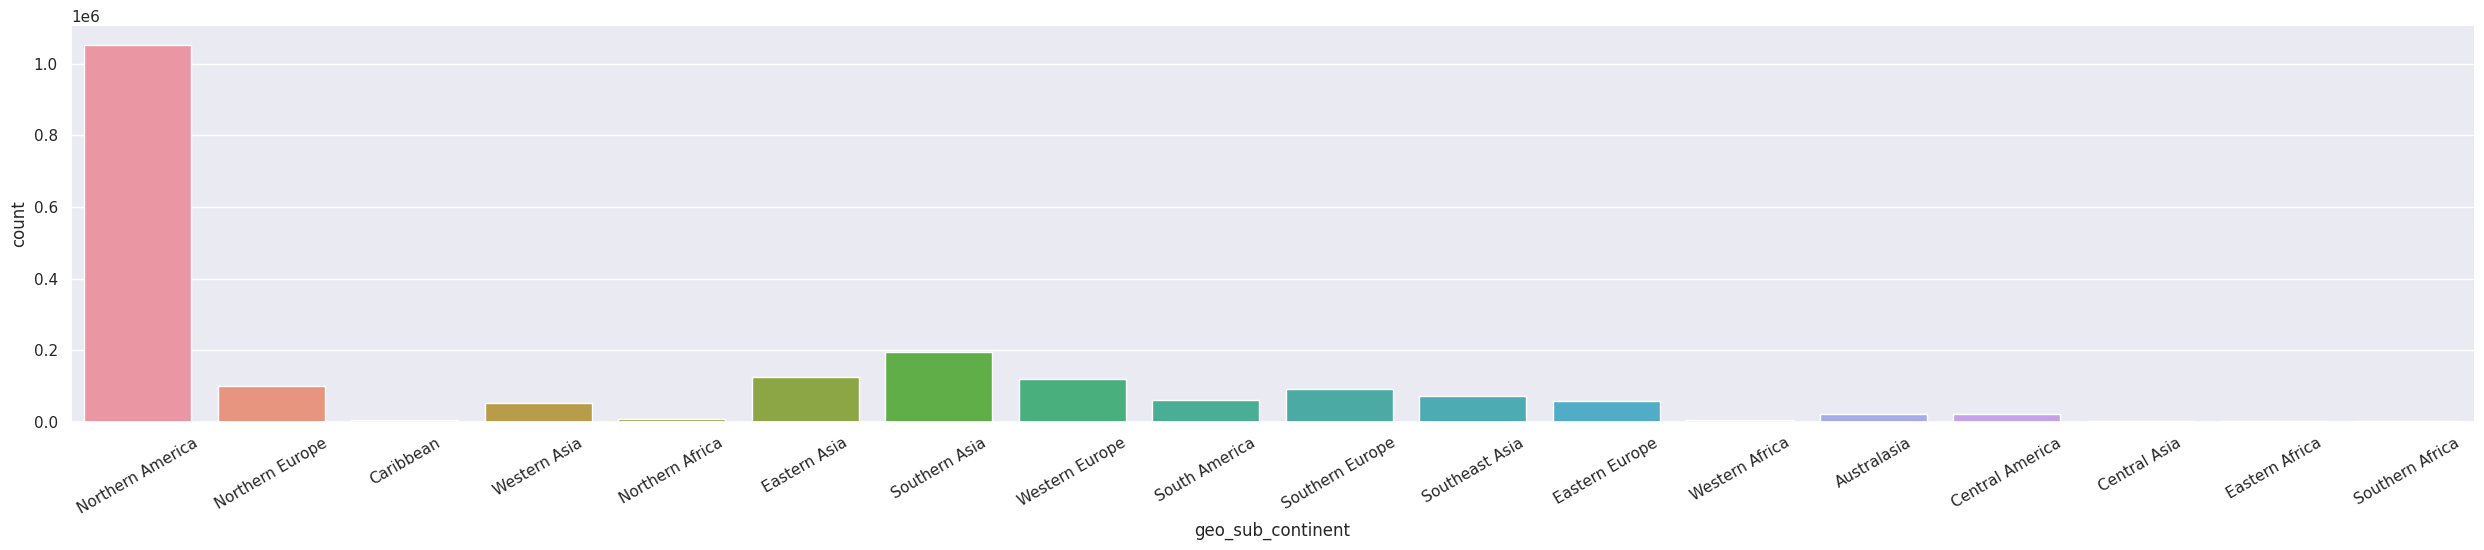

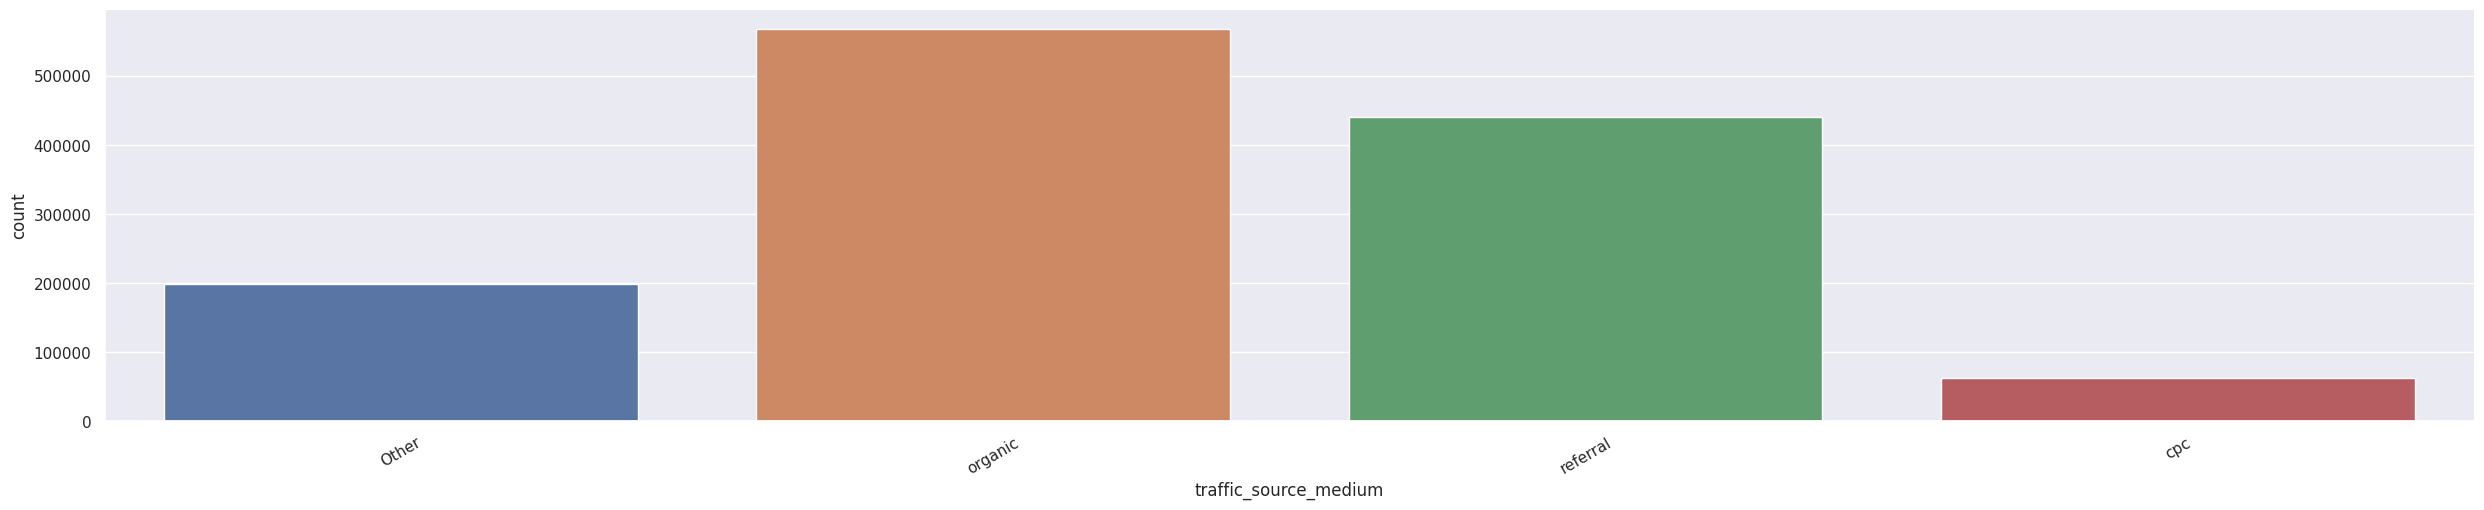

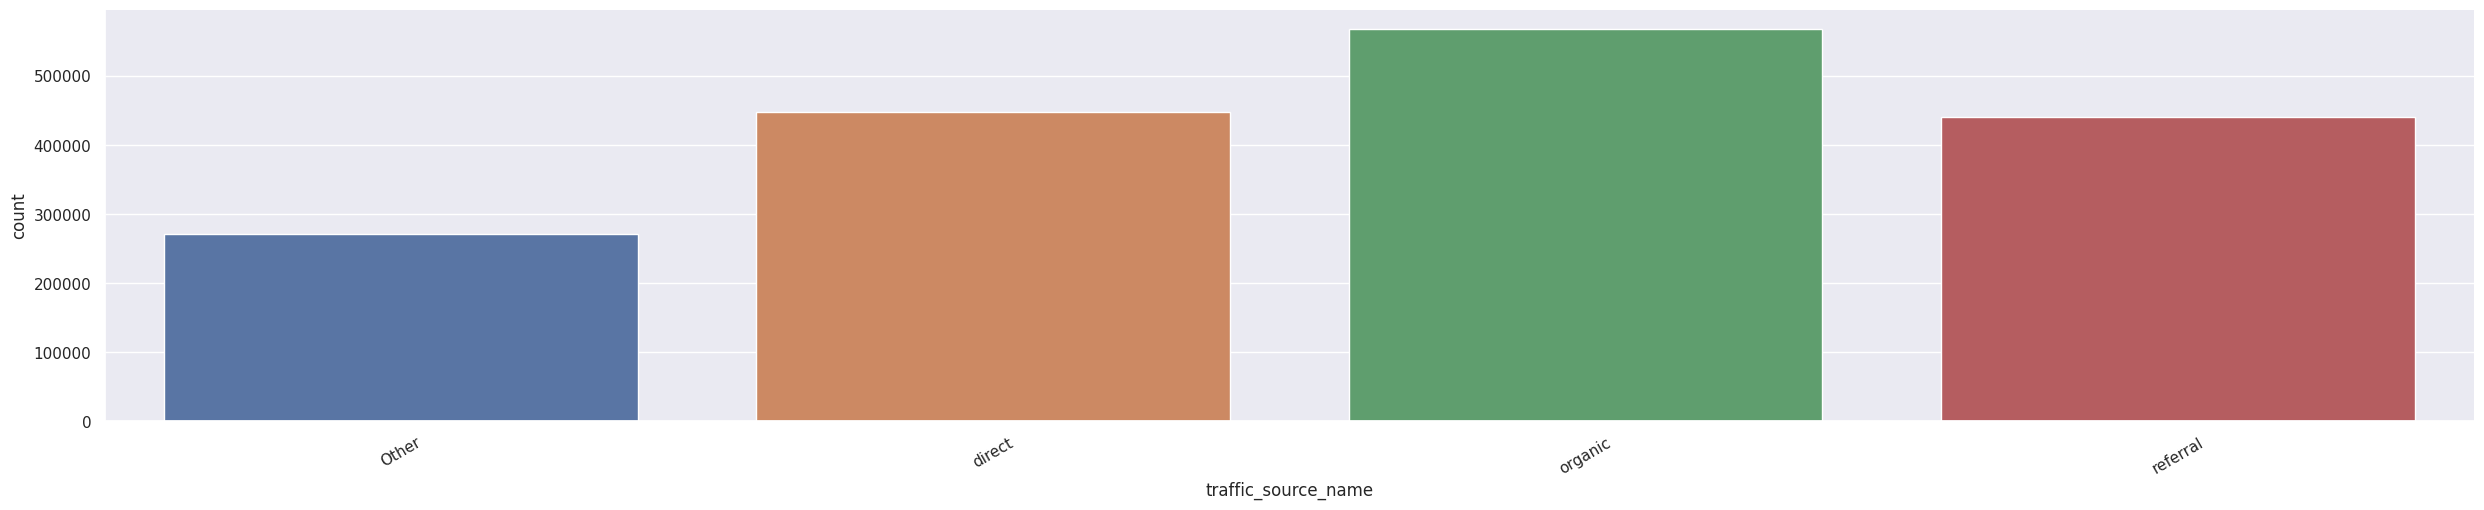

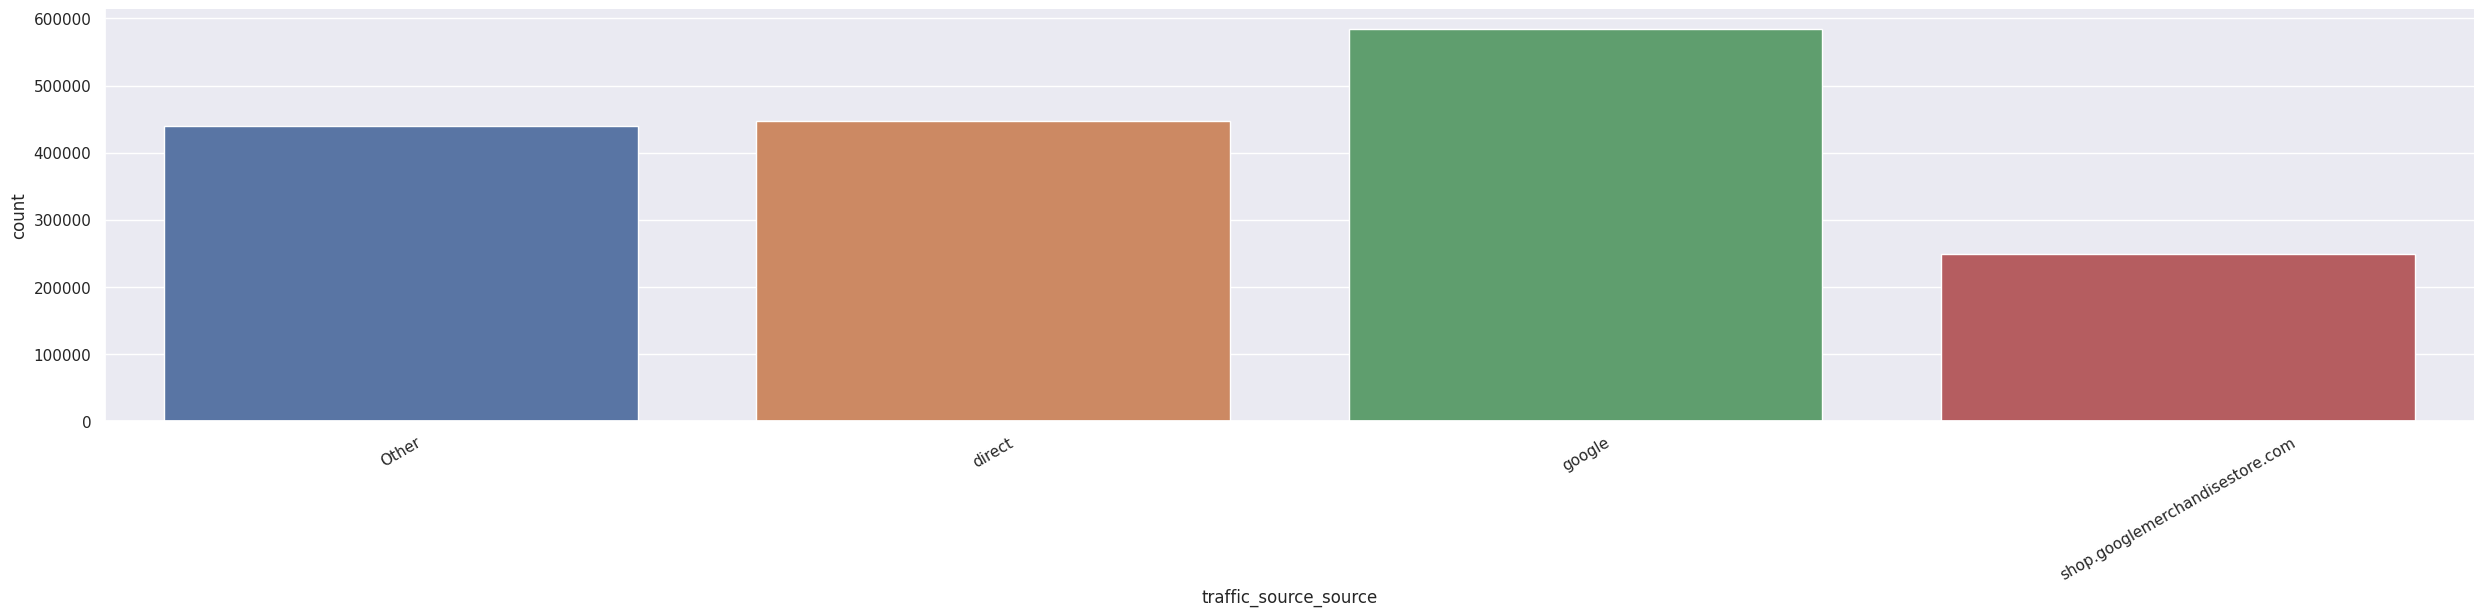

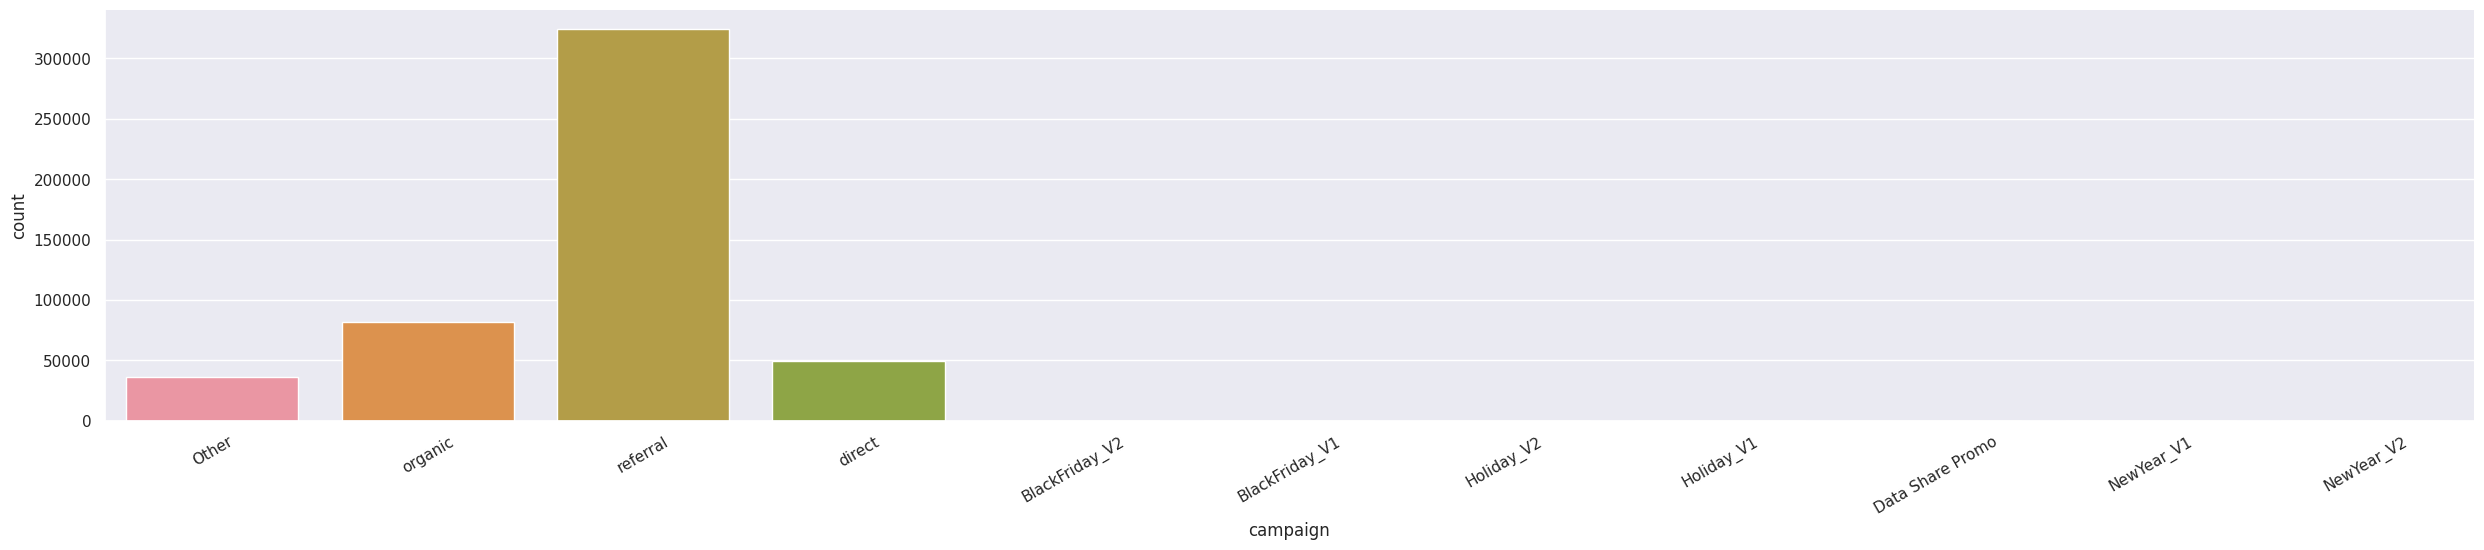

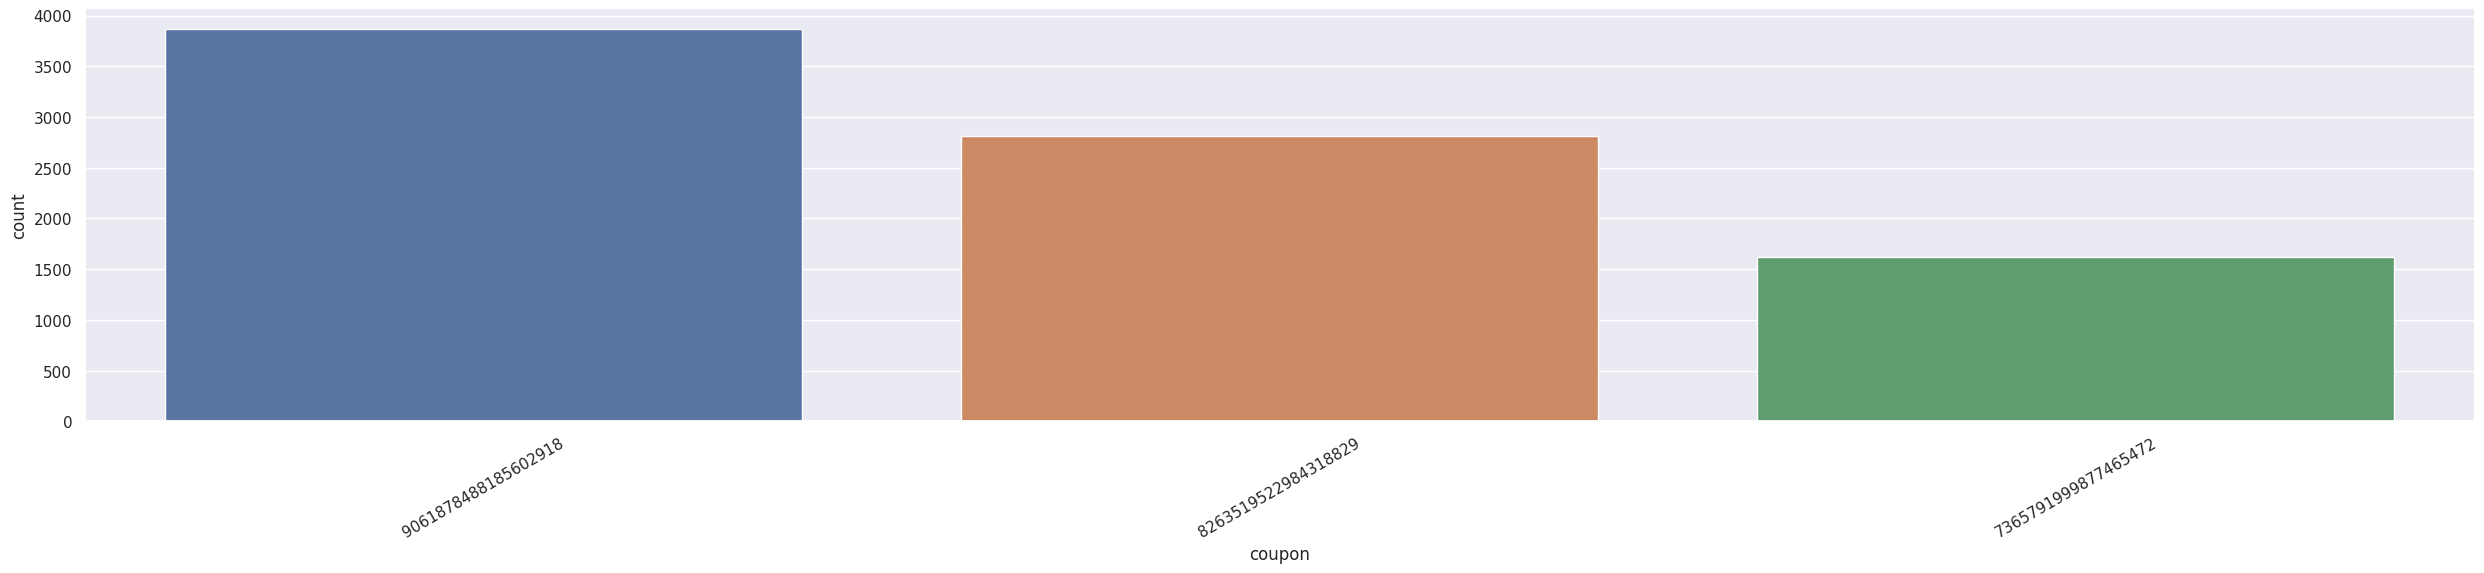

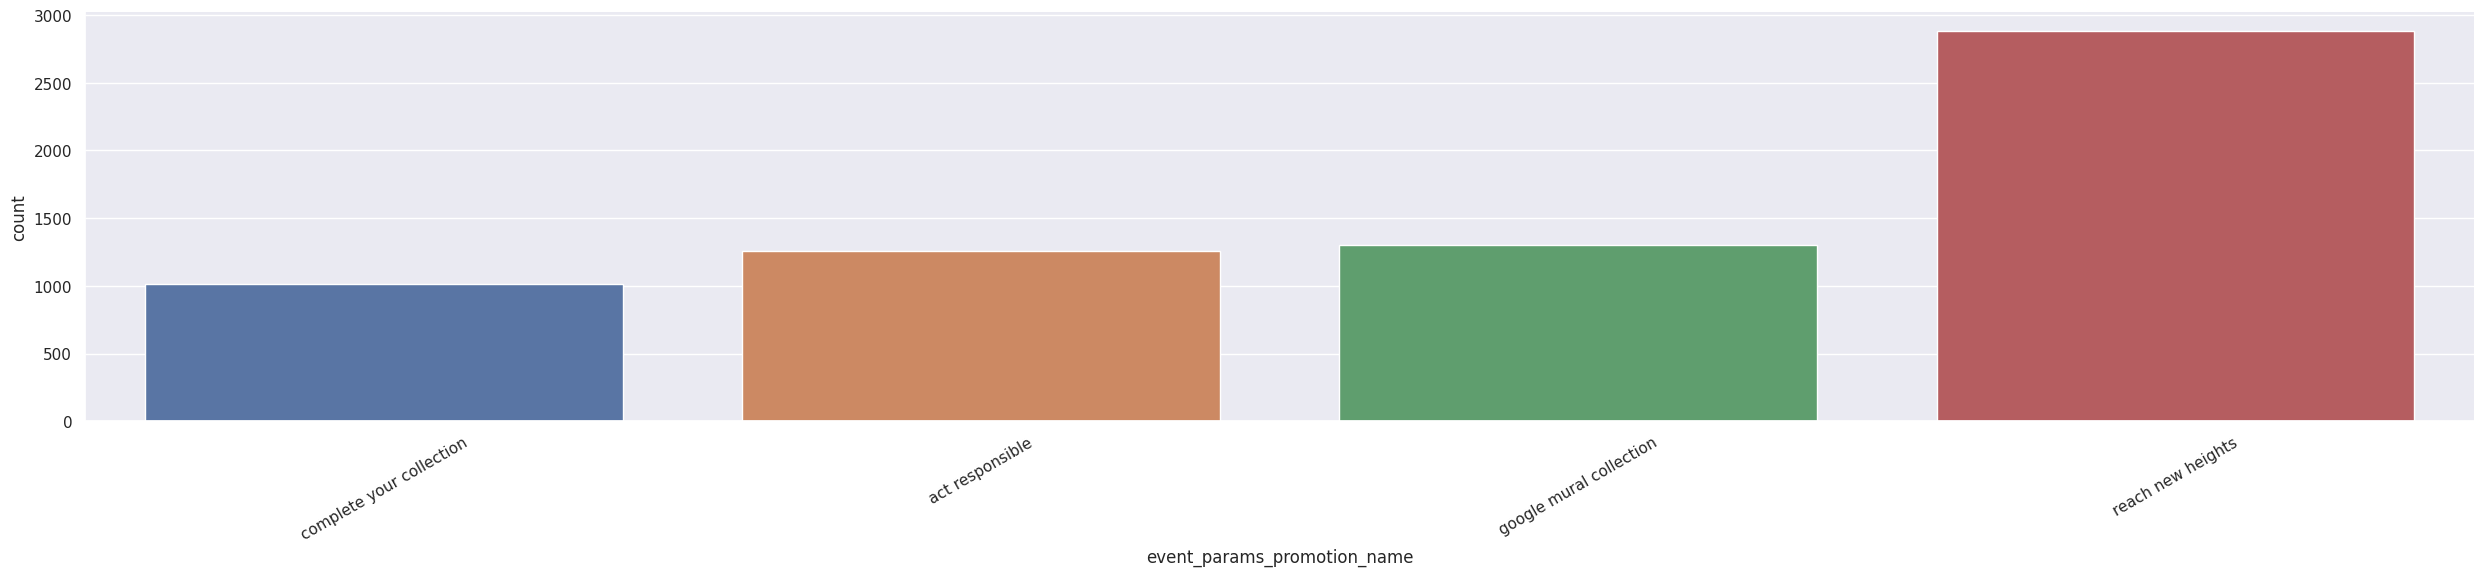

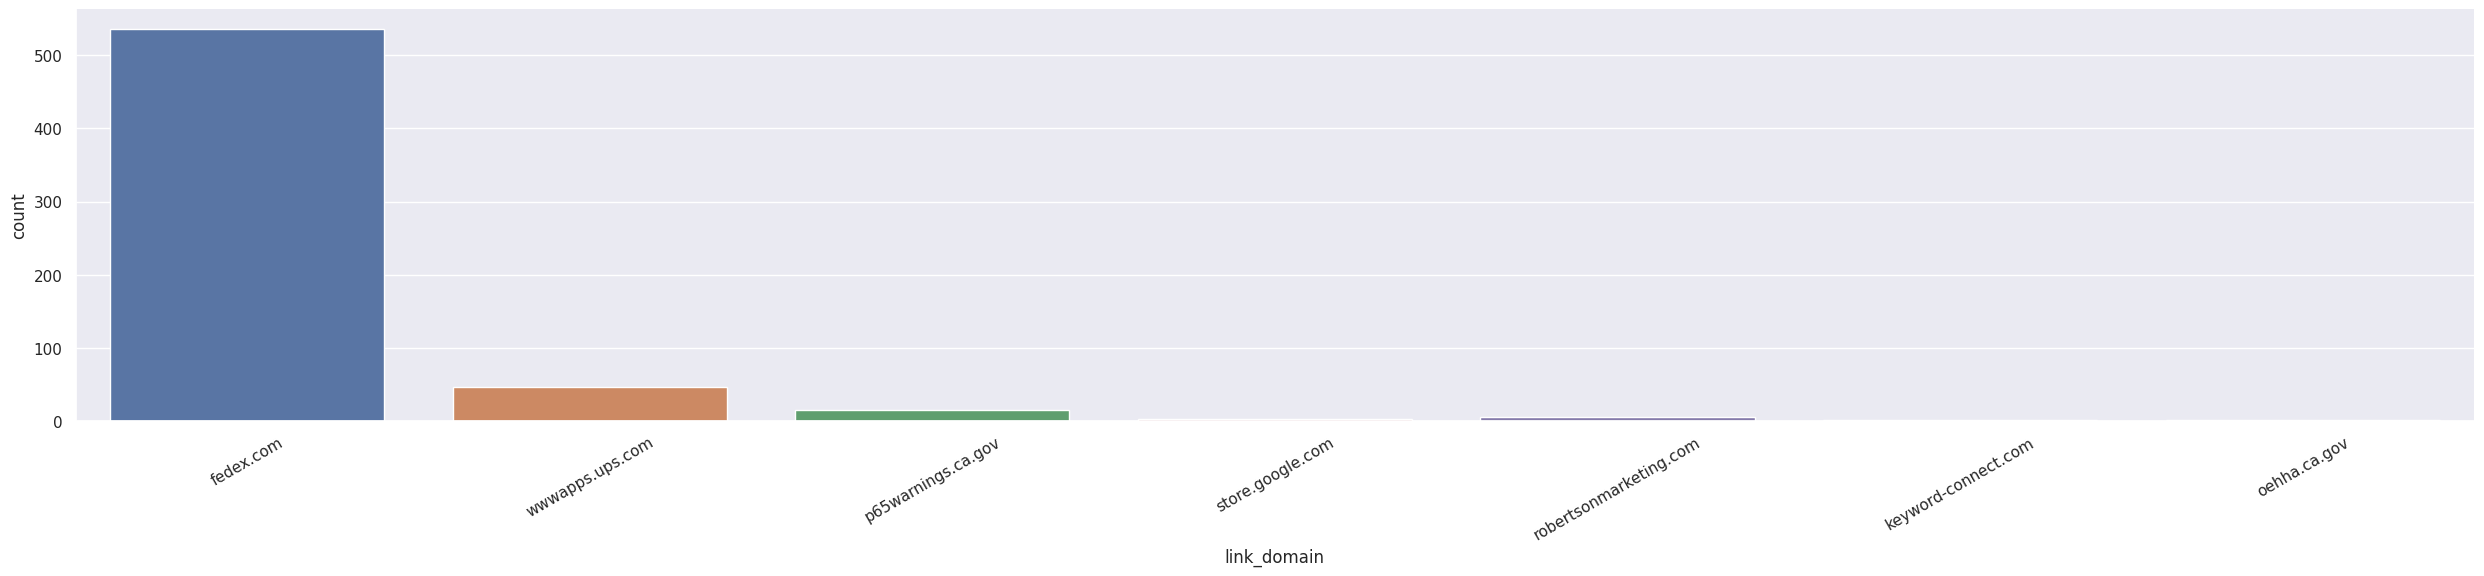

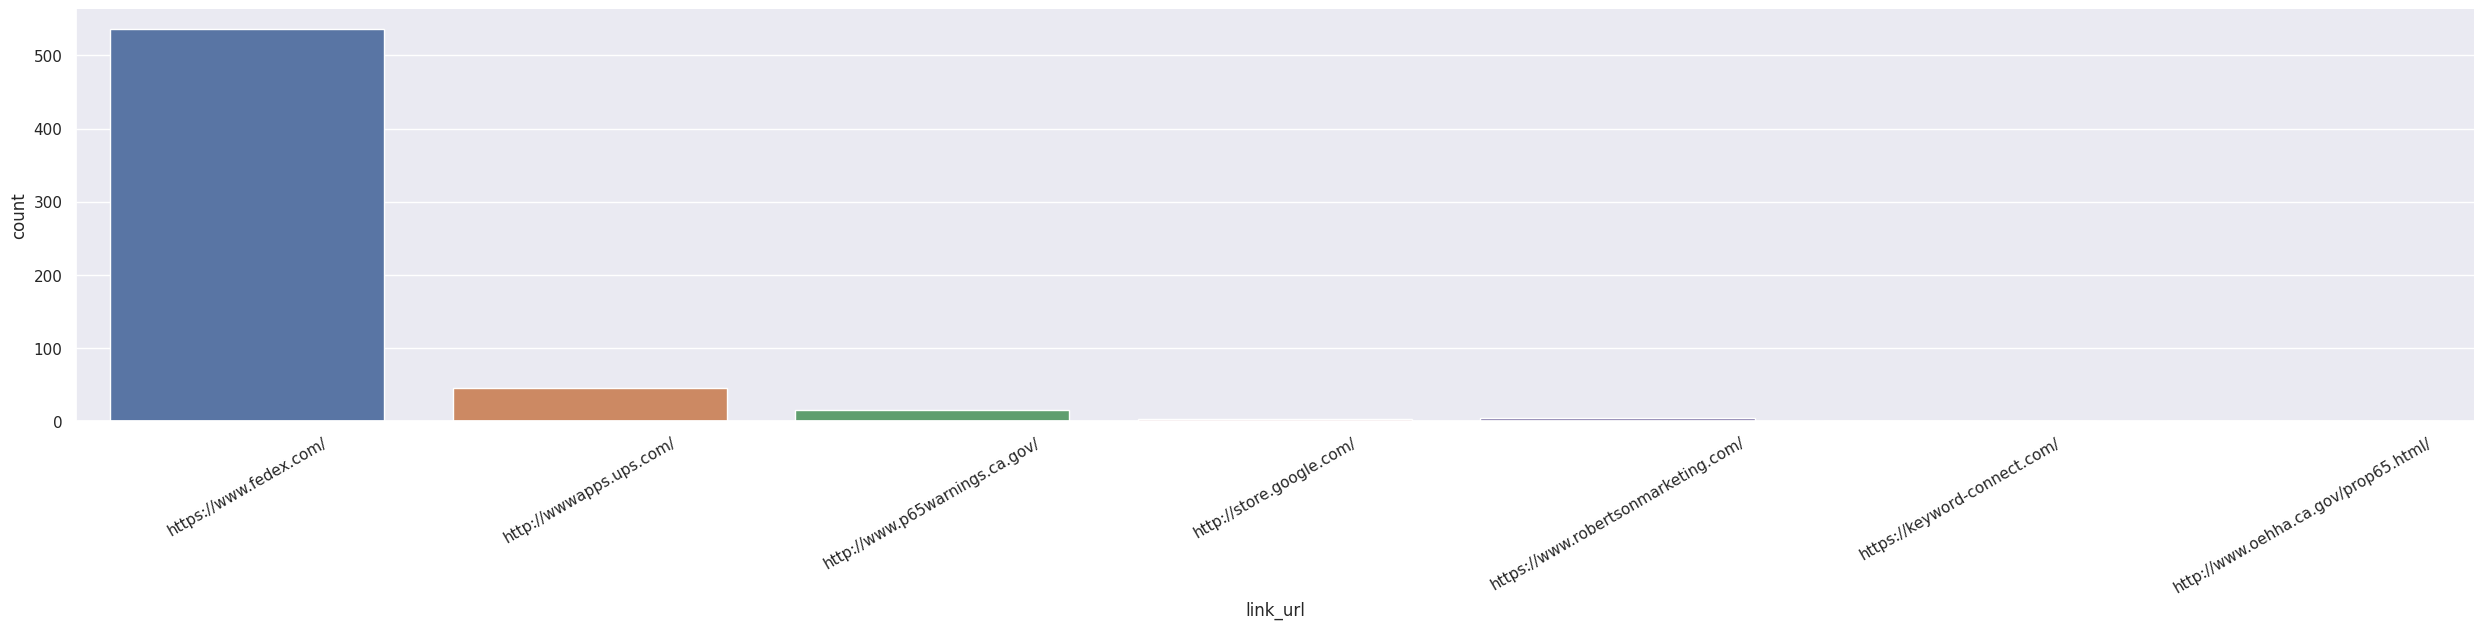

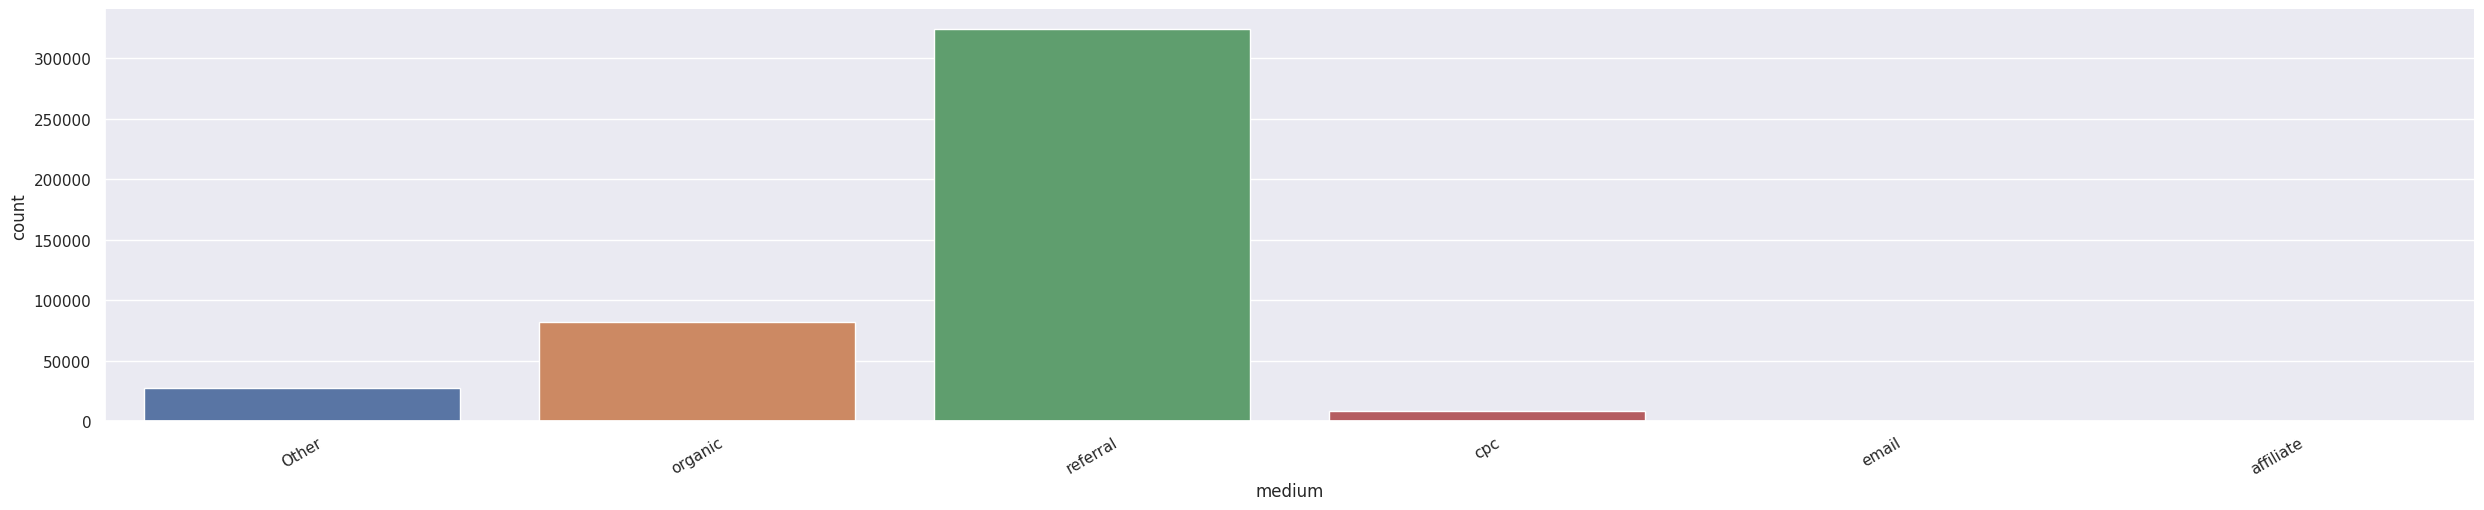

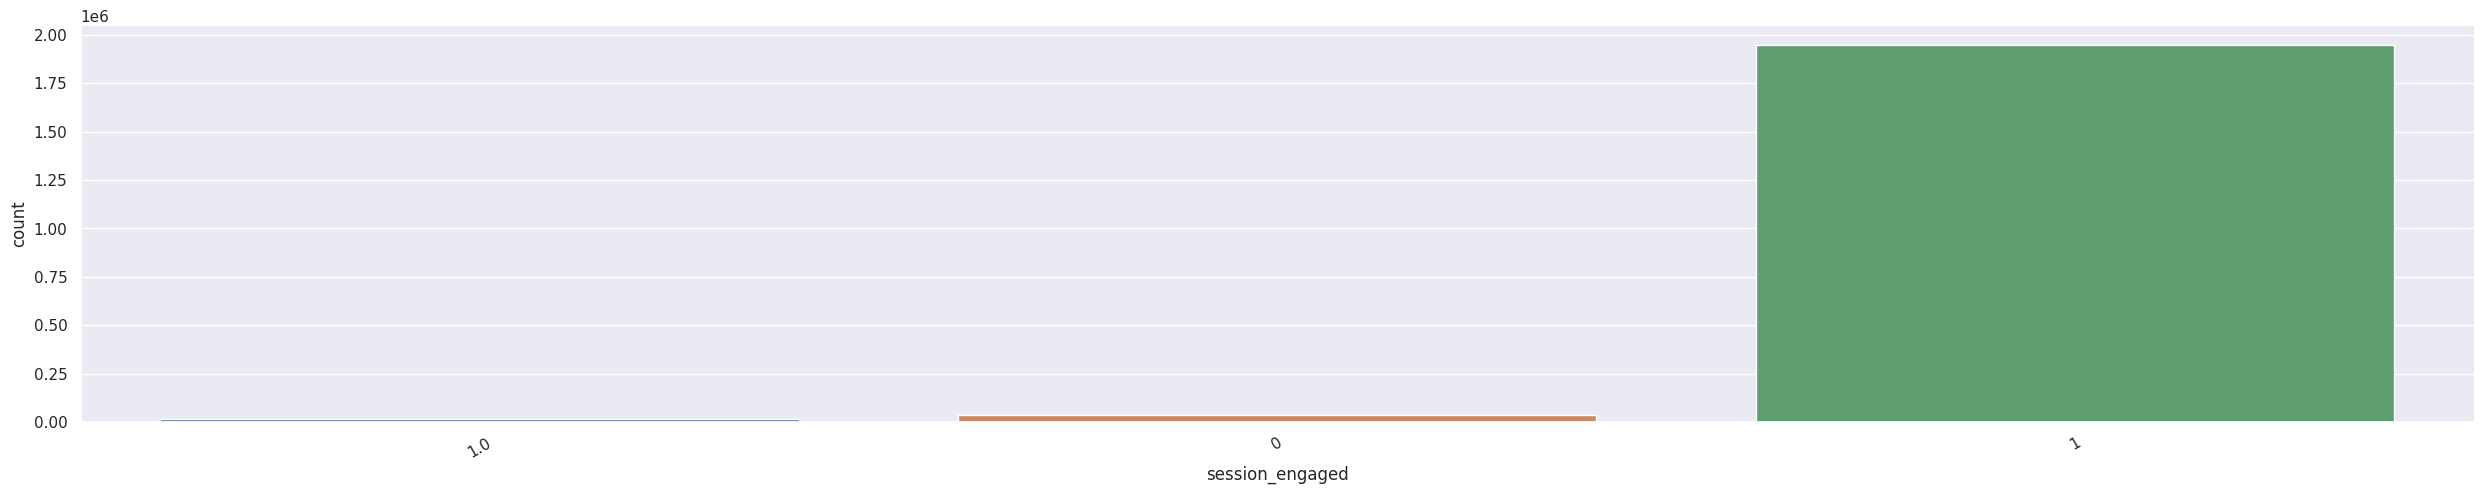

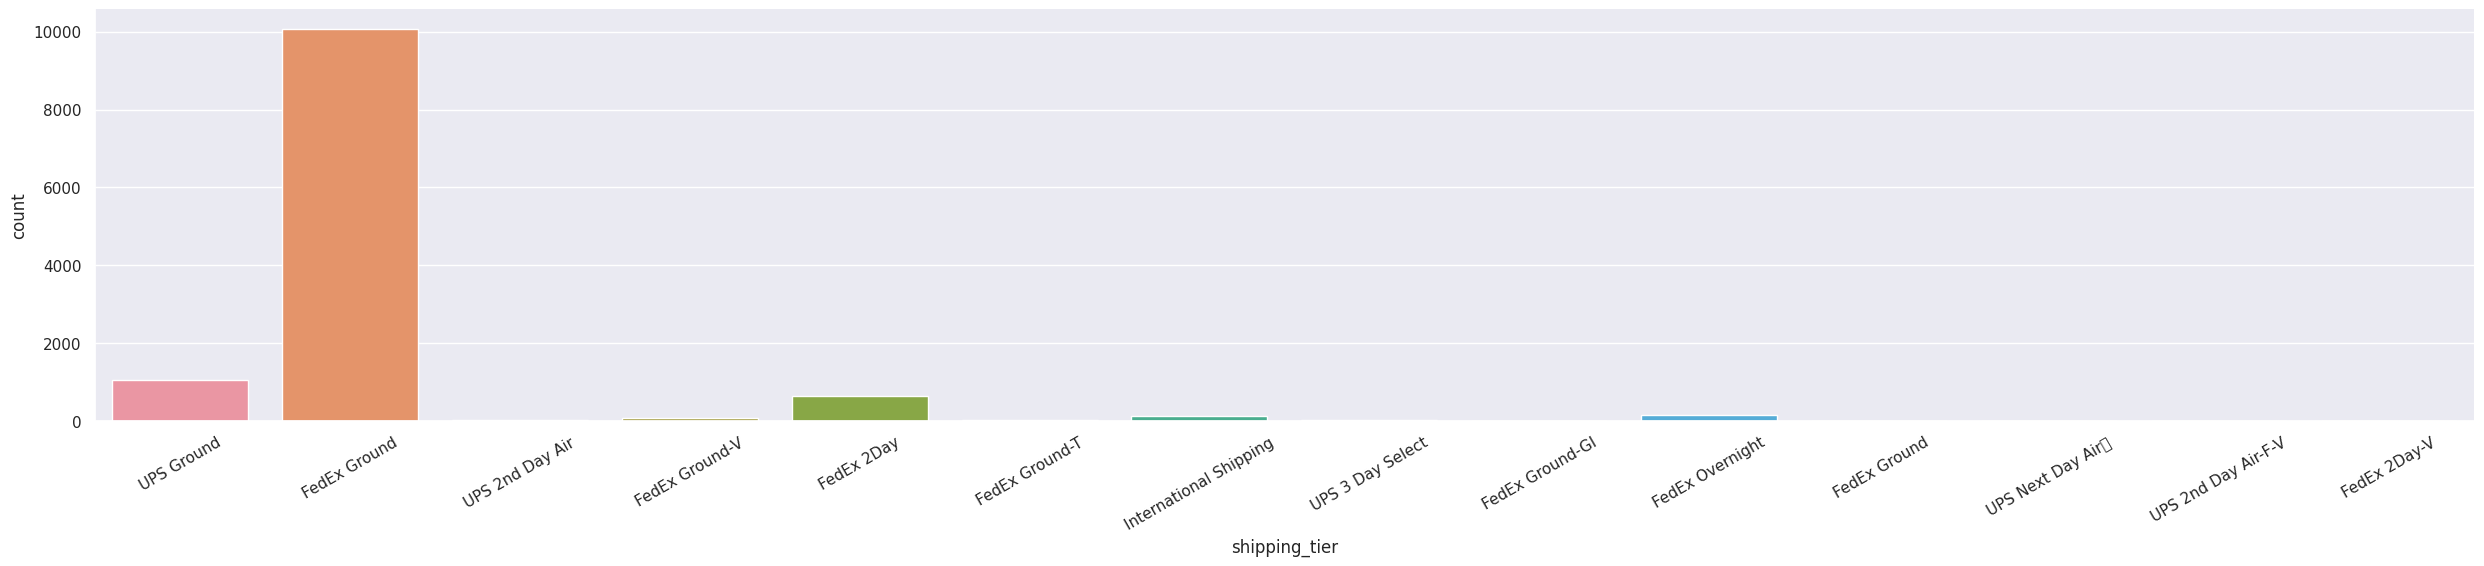

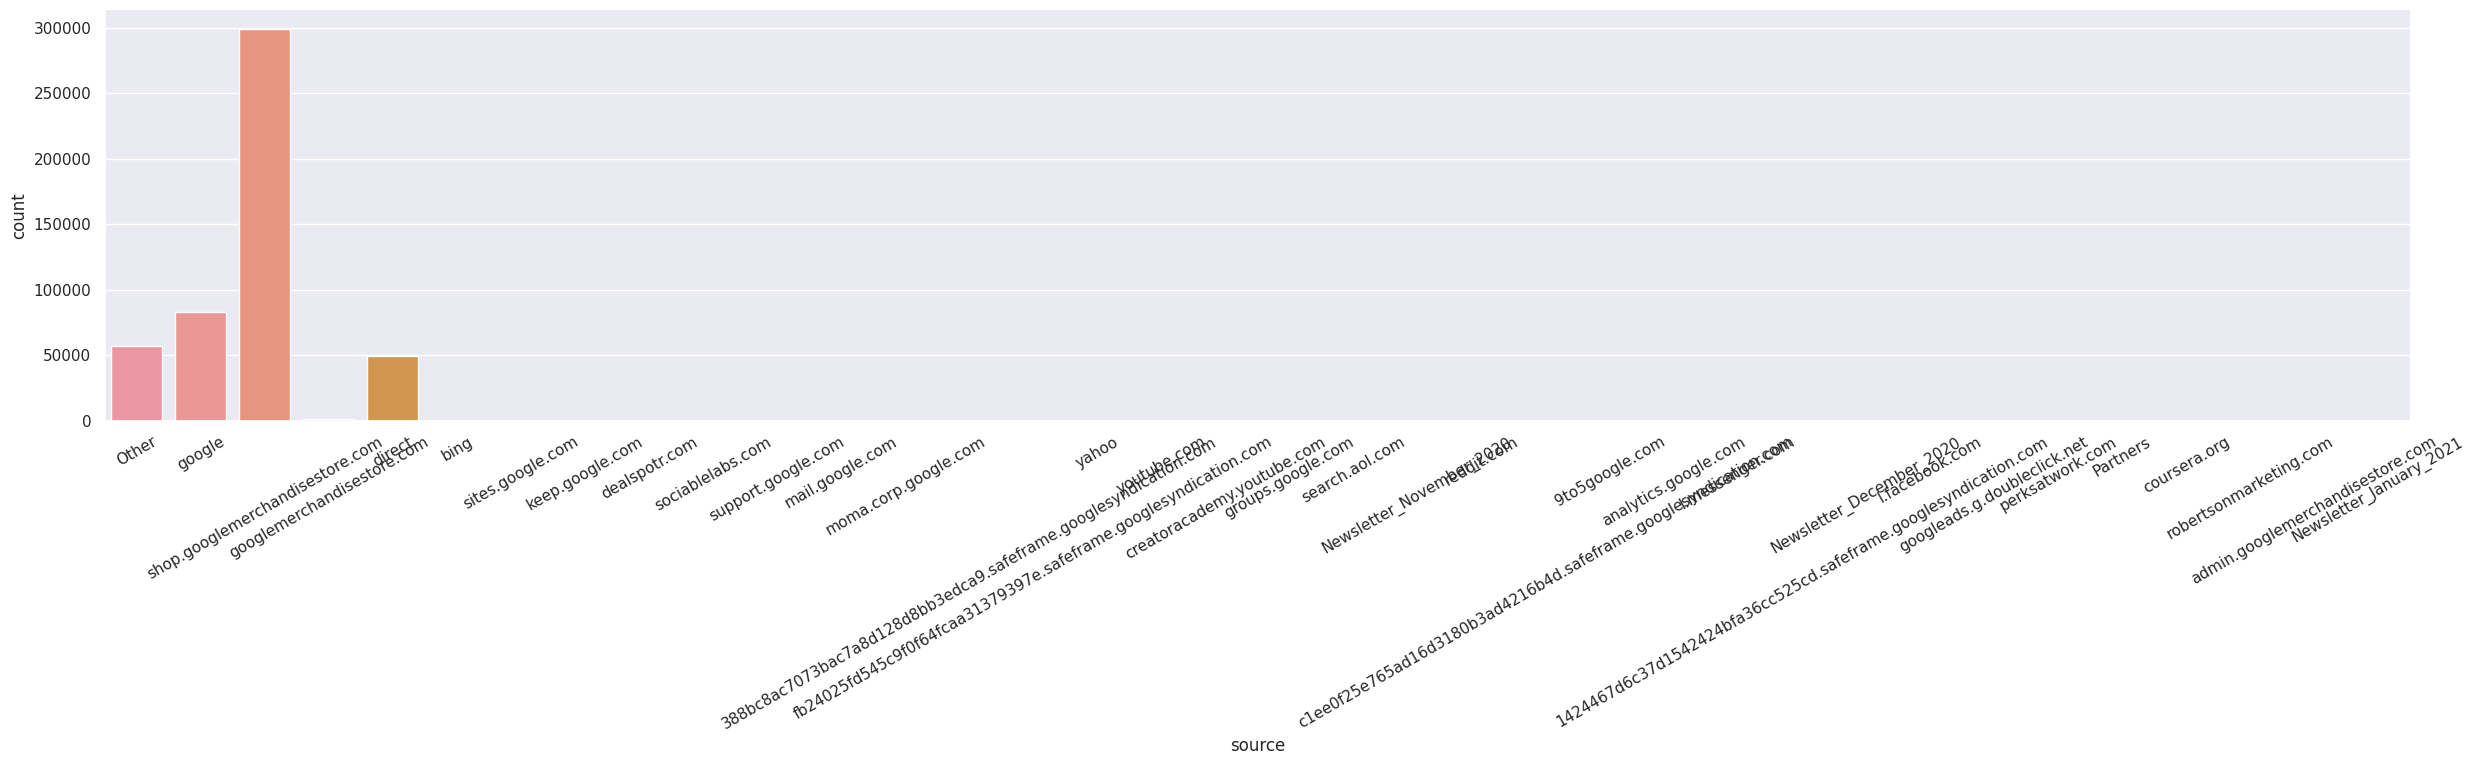

In [ ]:
# plot distributions of non-numeric features
for col in non_num_cols:
    if len(counts.get(col)) <= 50:
        sns.catplot(
            data=df_pivot,
            x=col,
            kind="count",
            height=5,
            aspect=5
        )
        plt.xticks(rotation=30)
        plt.show();

In [ ]:
id_cols = ['transaction_id',
           'ecommerce_transaction_id',
           'item_id',
           'user_pseudo_id',
           'ga_session_id']

In [ ]:
for col in non_num_cols:
    if col not in id_cols:
        print(col)
        print(df_pivot[col].value_counts(normalize=True, dropna=False))
        print()

event_date
20201211   0.035
20201209   0.034
20201215   0.031
20201130   0.030
20201210   0.029
            ... 
20210103   0.003
20210131   0.003
20210102   0.003
20210117   0.002
20201101   0.002
Name: event_date, Length: 92, dtype: float64

event_name
view_item             0.453
add_to_cart           0.150
page_view             0.114
user_engagement       0.105
scroll                0.056
select_item           0.053
begin_checkout        0.030
view_promotion        0.008
purchase              0.008
session_start         0.008
add_shipping_info     0.006
add_payment_info      0.006
first_visit           0.002
view_search_results   0.001
select_promotion      0.000
click                 0.000
Name: event_name, dtype: float64

item_name
NaN                                   0.313
Google Navy Speckled Tee              0.017
Super G Unisex Joggers                0.014
Google Zip Hoodie F/C                 0.013
Google Campus Bike Eco Tee Navy       0.013
                                 

### Non-numeric feature summary

* `event_date`:
    - The date on which the event was logged (YYYYMMDD format in the registered timezone of your app).
        - We'll need to convert this into datetime.
        - This is useful for aggregating transactions and sessions.
* `event_name`:
    - The name of the event.
        - There are 16 unique values.
        - `view_item` is the most frequently occurring value.
        - `purchase` will be an important event we'll use when creating the returns file. It makes up a very small portion of this data since the timeframe is limited, but you'll likely have a larger number of these to work with.
* `user_pseudo_id`:
    - The pseudonymous id (e.g., app instance ID) for the user.
        - We need this to associate multiple transactions and sessions with a single user.
* `item_id`:
    - The ID of the item.
        - We needed this for matching a return for a particular item. Now that the return data is combined, we can drop this.
        - **Drop this column.**
* `item_name`:
    - The name of the item.
        - This is likely too specific for our use case. We are already able to categorize each item based on other existing features.
        - **Drop this column.**
* `item_brand`:
    - The brand of the item.
        - A majority of the values are null (93.3%).
        - **Drop this column.**
* `item_variant`:
    - The variant of the item.
        - A majority of the values are null (95.8%).
        - **Drop this column.**
* `item_category`:
    - The category of the item.
        - We can clean this feature further down the line. It may be informative of what kinds of products a user browses most frequently.
* `item_list_id`:
    - The ID of the list in which the item was presented to the user.
        - This feature is likely not predictive of a return.
        - **Drop this column.**
* `item_list_index`:
    - The position of the item in a list.
        - This feature is likely not predictive of a return.
        - **Drop this column.**
* `promotion_name`:
    - The name of a product promotion.
        - We can use this column as a boolean feature to determine if a promotional code was used or not.
 * `device_category`:
    - The device category (mobile, tablet, desktop).
        - This feature may be predictive of the type of user, and thus a return.
* `device_mobile_brand_name`:
    - The device brand name.
        - This feature may be indicative of the type of user, and thus a return.
* `device_mobile_model_name`:
    - The device model name.
        - This feature may be indicative of the type of user, and thus a return.
* `device_operating_system`:
    - The operating system of the device.
        - This feature is overly specific and likely is not predictive of a return.
        - **Drop this column.**
* `device_operating_system_version`:
    - The OS version.
        - This feature is overly specific and likely is not predictive of a return.
        - **Drop this column.**
* `device_language`:
    - The OS language.
        - The values are overwhelmingly English (en-us, en-gb, en-ca).
        - **Drop this column.**
 * `device_web_info_browser`:
    - The browser in which the user viewed content.
        - This feature may be predictive of the type of user, and thus a return.
* `device_web_info_browser_version`:
    - The version of the browser in which the user viewed content.
        - This is overly specific and not likely to be predictive of a return.
        - **Drop this column.**
* `geo_continent`:
    - The continent from which events were reported, based on IP address.
        - This feature is too broad and we will only retain one geo-feature. This feature can be inferred from the geo feature which we retain.
        - **Drop this column.**
* `geo_sub_continent`:
    - The subcontinent from which events were reported, based on IP address.
        - This feature is too broad and we will only retain one geo-feature. This feature can be inferred from the geo feature which we retain.
        - **Drop this column.**
* `geo_country`:
    - The country from which events were reported, based on IP address.
        - We will retain this geo feature. It has enough diversity in it to represent most users.
* `geo_region`:
    - The region from which events were reported, based on IP address.
        - This feature is too specific for our purposes.
        - **Drop this column.**
* `geo_city`:
    - The city from which events were reported, based on IP address.
        - This feature is too specific for our purposes and has a large percentage of null values (42.6%).
        - **Drop this column.**
* `traffic_source_medium`:
    - Name of the medium (paid search, organic search, email, etc.) that first acquired the user. This field is not populated in intraday tables.
        - This feature can be used to classify customers and thus, return habits.
* `traffic_source_name`:
    - Name of the marketing campaign that first acquired the user. This field is not populated in intraday tables.
        - This is redundant with `traffic_source_medium`, so just retain that one.
        - **Drop this column.**
* `traffic_source_source`:
    - Name of the network that first acquired the user. This field is not populated in intraday tables.
        - The values are all Google, so they are not predictive.
        - **Drop this column.**
* `ecommerce_transaction_id`:
    - The transaction ID of the ecommerce transaction.
        - This feature is necessary for aggregating to the transaction level.
* `campaign`:
    - The campaign value.
        - This feature is a majority null (74.5%)
        - **Drop this column.**
* `coupon`:
    - The coupon code associated with the transaction.
        - This feature is overwhelmingly null (99.6%)
        - **Drop this column.**
* `event_params_promotion_name`:
    - Promotion Name.
        - This feature is overwhelmingly null (99.7%)
        - **Drop this column.**
* `ga_session_id`:
    - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user.
        - This is necessary for aggregating all of a user's sessions.  
* `link_domain`:
    - There is no official documentation for this feature.
        - This feature is overwhelmingly null (99.6%). Those that are not null are all fedex.com.
        - **Drop this column.**
* `link_url`:
    - There is no official documentation for this feature.
        - This feature is overwhelmingly null (99.6%). Those that are not null are all fedex.com.
        - **Drop this column.**
* `medium`:
    - Name of the medium (paid search, organic search, email, etc.) that first acquired the user. This field is not populated in intraday tables.
        - This feature is a majority null (74.5%).
        - **Drop this column.**
* `page_location`:
    - There is no official documentation for this feature.
        - This feature is overly specific with 2517 unique values and is not likely to be predictive of a return.
        - **Drop this column.**
* `page_referrer`:
    - The referring page, if the session has a goal completion or transaction. If this page is from the same domain, this is blank.
        - This feature is overwhelmingly null (96.5%) and the values are overly specific.
        - **Drop this column.**
* `page_title`:
    - The page title.
        - This feature can be used to determine a user's browsing habits, and determine what type of customer they are.
* `session_engaged`:
    - There is no official documentation for this feature.
        - We will convert this feature to boolean.
* `shipping_tier`:
    - This field is populated when a checkout option is specified. For example, a shipping option such as option = 'FedEx Ground'.
        - A majority of the values are null (99.4%).
        - **Drop this column.**
* `source`:
    - Name of the network that first acquired the user. This field is not populated in intraday tables.
        - This feature is redundant with `traffic_source_medium`.
        - **Drop this column.**
* `transaction_id`:
    - The transaction ID of the ecommerce transaction.
        - This feature is redundant with `ecommerce_transaction_id`.
        - **Drop this column.**

In [ ]:
drop_non_num_cols = ['item_id',
                     'item_name',
                     'item_brand',
                     'item_variant',
                     'item_list_id',
                     'item_list_index',
                     'device_operating_system',
                     'device_operating_system_version',
                     'device_language',
                     'device_web_info_browser_version',
                     'geo_continent',
                     'geo_sub_continent',
                     'geo_region',
                     'geo_city',
                     'traffic_source_name',
                     'traffic_source_source',
                     'campaign',
                     'coupon',
                     'event_params_promotion_name',
                     'link_domain',
                     'link_url',
                     'medium',
                     'page_location',
                     'page_referrer',
                     'shipping_tier',
                     'source',
                     'transaction_id']

In [ ]:
df_pivot = df_pivot.drop(drop_non_num_cols, axis=1)

In [ ]:
df_pivot = df_pivot.rename({'engagement_time_msec': 'event_params_engagement_time_msec',
                            'ga_session_id': 'event_params_ga_session_id',
                            'ga_session_number': 'event_params_ga_session_number',
                            'session_engaged': 'event_params_session_engaged',
                            'page_title': 'event_params_page_title',
                            'purchase_revenue_in_usd': 'ecommerce_purchase_revenue_in_usd',
                            'transaction_return_quantity': 'total_return_item_quantity',
                            'price_in_usd': 'item_price_in_usd',
                            'quantity': 'item_quantity',
                            'promotion_name': 'item_promotion_name'},
                           axis=1)

In [ ]:
df_pivot['item_refund_in_usd'] = df_pivot['item_refund_quantity'] * df_pivot['item_price_in_usd']

In [ ]:
df_pivot = df_pivot[['event_date',
                     'event_name',
                     'event_params_engagement_time_msec',
                     'event_params_ga_session_id',
                     'event_params_ga_session_number',
                     'event_params_page_title',
                     'event_params_session_engaged',
                     'user_pseudo_id',
                     'user_ltv_revenue',
                     'device_category',
                     'device_mobile_brand_name',
                     'device_mobile_model_name',
                     'device_web_info_browser',
                     'geo_country',
                     'traffic_source_medium',
                     'ecommerce_total_item_quantity',
                     'ecommerce_purchase_revenue_in_usd',
                     'total_return_item_quantity',
                     'ecommerce_tax_value_in_usd',
                     'ecommerce_unique_items',
                     'ecommerce_transaction_id',
                     'item_category',
                     'item_price_in_usd',
                     'item_quantity',
                     'item_revenue_in_usd',
                     'item_refund_in_usd',
                     'item_refund_quantity',
                     'item_promotion_name']]

In [ ]:
df_pivot

key,event_date,event_name,event_params_engagement_time_msec,event_params_ga_session_id,event_params_ga_session_number,event_params_page_title,event_params_session_engaged,user_pseudo_id,user_ltv_revenue,device_category,device_mobile_brand_name,device_mobile_model_name,device_web_info_browser,geo_country,traffic_source_medium,ecommerce_total_item_quantity,ecommerce_purchase_revenue_in_usd,total_return_item_quantity,ecommerce_tax_value_in_usd,ecommerce_unique_items,ecommerce_transaction_id,item_category,item_price_in_usd,item_quantity,item_revenue_in_usd,item_refund_in_usd,item_refund_quantity,item_promotion_name
0,20201101,first_visit,0,6944996097,1,Men's / Unisex | Apparel | Google Merchandise ...,1.000,36638696.4029295753,0.000,mobile,Samsung,Other,Chrome,United States,Other,0,0.000,0,0.000,0,NaN,NaN,0.000,0,0.000,0.000,0,NaN
1,20201101,page_view,0,6944996097,1,Men's / Unisex | Apparel | Google Merchandise ...,0,36638696.4029295753,0.000,mobile,Samsung,Other,Chrome,United States,Other,0,0.000,0,0.000,0,NaN,NaN,0.000,0,0.000,0.000,0,NaN
2,20201101,session_start,0,6944996097,1,Men's / Unisex | Apparel | Google Merchandise ...,NaN,36638696.4029295753,0.000,mobile,Samsung,Other,Chrome,United States,Other,0,0.000,0,0.000,0,NaN,NaN,0.000,0,0.000,0.000,0,NaN
3,20201101,user_engagement,8919,6944996097,1,Men's / Unisex | Apparel | Google Merchandise ...,0,36638696.4029295753,0.000,mobile,Samsung,Other,Chrome,United States,Other,0,0.000,0,0.000,0,NaN,NaN,0.000,0,0.000,0.000,0,NaN
4,20201101,page_view,0,6944996097,1,Apparel | Google Merchandise Store,1,36638696.4029295753,0.000,mobile,Samsung,Other,Chrome,United States,Other,0,0.000,0,0.000,0,NaN,NaN,0.000,0,0.000,0.000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002005,20210131,page_view,0,8197357339,3,Payment Method,1,6801821.5367611951,0.000,desktop,Google,Chrome,Chrome,Iraq,organic,0,0.000,0,0.000,0,NaN,NaN,0.000,0,0.000,0.000,0,NaN
2002006,20210131,user_engagement,22760,8197357339,3,Payment Method,1,6801821.5367611951,0.000,desktop,Google,Chrome,Chrome,Iraq,organic,0,0.000,0,0.000,0,NaN,NaN,0.000,0,0.000,0.000,0,NaN
2002007,20210131,page_view,0,8197357339,3,Checkout Confirmation,1,6801821.5367611951,0.000,desktop,Google,Chrome,Chrome,Iraq,organic,0,0.000,0,0.000,0,NaN,NaN,0.000,0,0.000,0.000,0,NaN
2002008,20210131,purchase,4,8197357339,3,Checkout Confirmation,1,6801821.5367611951,0.000,desktop,Google,Chrome,Chrome,Iraq,organic,0,0.000,0,0.000,1,None,None,0.000,0,0.000,0.000,0,None


In [ ]:
df_pivot['event_params_session_engaged'] = df_pivot.event_params_session_engaged.astype(float)

# Write data back to gbq

In [ ]:
# create table schema to prevent errors when uploading data
schema = []

for col, dtype in zip(df_pivot.dtypes.index, df_pivot.dtypes.values):
    col_dict = {}
    col_dict['name'] = col

    if dtype == object:
        typ = 'STRING'
    elif dtype == bool:
        typ = 'BOOLEAN'
    elif dtype in [int, 'Int64', 'int64']:
        typ = 'INTEGER'
    elif dtype in [float, 'Float64', 'float64']:
        typ = 'FLOAT'
    else:
        print(col)
        print(dtype)
        print()

    col_dict['type'] = typ

    schema.append(col_dict)

In [ ]:
schema

[{'name': 'event_date', 'type': 'STRING'},
 {'name': 'event_name', 'type': 'STRING'},
 {'name': 'event_params_engagement_time_msec', 'type': 'INTEGER'},
 {'name': 'event_params_ga_session_id', 'type': 'STRING'},
 {'name': 'event_params_ga_session_number', 'type': 'INTEGER'},
 {'name': 'event_params_page_title', 'type': 'STRING'},
 {'name': 'event_params_session_engaged', 'type': 'FLOAT'},
 {'name': 'user_pseudo_id', 'type': 'STRING'},
 {'name': 'user_ltv_revenue', 'type': 'FLOAT'},
 {'name': 'device_category', 'type': 'STRING'},
 {'name': 'device_mobile_brand_name', 'type': 'STRING'},
 {'name': 'device_mobile_model_name', 'type': 'STRING'},
 {'name': 'device_web_info_browser', 'type': 'STRING'},
 {'name': 'geo_country', 'type': 'STRING'},
 {'name': 'traffic_source_medium', 'type': 'STRING'},
 {'name': 'ecommerce_total_item_quantity', 'type': 'INTEGER'},
 {'name': 'ecommerce_purchase_revenue_in_usd', 'type': 'FLOAT'},
 {'name': 'total_return_item_quantity', 'type': 'INTEGER'},
 {'name':

In [ ]:
df_pivot.to_gbq(f'{project_name}.public_sample_data.return_prediction_ga4_1b',
                  project_id=project_name,
                  if_exists='replace',
                  location=region,
                  chunksize=100_000,
                  table_schema=schema)

100%|██████████| 1/1 [00:00<00:00, 11366.68it/s]
